<a href="https://colab.research.google.com/github/varun-ml/diffusion-models-tutorial/blob/master/emnist-colab-notebooks/colab_EMNIST_conditional.diffusion_model.large.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating complex densities using Diffusion models

1. moving to alphabets and number generation using diffusion models
    * We will be using JAX
    * Using U-net blocks for modelling the denoising process
    * With class conditioning
    * with batch norm to speed up training

In [ ]:
!pip install --upgrade -q clu einops dm-haiku optax flax
!pip install --upgrade -q dm-tree graphviz imageio[ffmpeg]

     |████████████████████████████████| 92 kB 263 kB/s 
     |████████████████████████████████| 41 kB 166 kB/s 
     |████████████████████████████████| 352 kB 68.8 MB/s 
     |████████████████████████████████| 154 kB 73.7 MB/s 
     |████████████████████████████████| 189 kB 63.0 MB/s 
     |████████████████████████████████| 77 kB 6.2 MB/s 
     |████████████████████████████████| 85 kB 4.4 MB/s 
     |████████████████████████████████| 8.3 MB 63.4 MB/s 
     |████████████████████████████████| 237 kB 72.7 MB/s 
     |████████████████████████████████| 51 kB 7.3 MB/s 
     |████████████████████████████████| 47 kB 4.1 MB/s 
     |████████████████████████████████| 26.9 MB 64.6 MB/s 


In [ ]:
import haiku as hk
import jax
import jax.numpy as jnp
import einops
import math
from typing import Iterator, Mapping, Tuple
from copy import deepcopy
import time
from absl import app
import haiku as hk
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow_datasets as tfds
import tensorflow as tf
from functools import partial
import math
import os
from flax import jax_utils

colab = True

if not colab:
  os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
  jax.config.update('jax_platform_name', 'cpu')
Batch = Tuple[np.ndarray, np.ndarray]

In [ ]:
if colab:
  from google.colab import drive
  drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_new_model = True
cont=False
model_name = 'emnist_fixed_with_cond.jax_version.large'

import os
import os.path as osp

if not colab:
  data_paths = osp.join(os.getcwd(), 'saved', 'saved_data')
  model_paths = osp.join(os.getcwd(), 'saved','saved_models')
  gifs_dir = osp.join(os.getcwd(), 'gifs')+"/"
  dataset_path = "/home/varun/tensorflow_datasets/"
else:
  data_paths = F"/content/gdrive/MyDrive/EMNIST/data/"
  model_paths = F"/content/gdrive/MyDrive/EMNIST/model/"
  gifs_dir = F"/content/gdrive/MyDrive/EMNIST/gifs/"
  dataset_path = F"/content/gdrive/MyDrive/EMNIST/dataset/"

In [ ]:
# utils 
import pickle

def load_cached(filename):
    with open(filename, 'rb') as ff:
        return pickle.load(ff)
    
def write_cached(data, filename):
    with open(filename, 'wb') as ff:
        pickle.dump(data, ff, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# train model

# ####### i am not getting desired results with the cosine beta schedule from the hugging face repo
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = jnp.linspace(0, timesteps, steps)
    alphas_cumprod = jnp.cos(((x / timesteps) + s) / (1 + s) * jnp.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return jnp.clip(betas, 0.0001, 0.1)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return jnp.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return jnp.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = jnp.linspace(-6, 6, timesteps)
    return jnp.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [ ]:
# Train model
timesteps = 250
# betas = linear_beta_schedule(timesteps)
betas = cosine_beta_schedule(timesteps)
alphas = 1 - betas
alphas_ = jnp.cumprod(alphas, axis=0)
variance = 1 - alphas_
sd = jnp.sqrt(variance)

alphas_prev_ = jnp.pad(alphas_[:-1], [1, 0], "constant", constant_values=1.0)
sigma_squared_q_t = (1 - alphas) * (1 - alphas_) / (1 - alphas_prev_)
log_sigma_squared_q_t = jnp.log(1-alphas) + jnp.log(1-alphas_) - jnp.log(1-alphas_prev_)
sigma_squared_q_t_corrected = jnp.exp(log_sigma_squared_q_t)
key = jax.random.PRNGKey(42)

# how to add noise to the data
@jax.jit
def get_noisy(rng, batch, timestep):
    timestep = einops.repeat(timestep, 'b -> b 28 28 1')
    # we will use the reparameterization trick
    # need to generate new keys everytime
    _, noise_key = jax.random.split(rng)
    noise_at_t = jax.random.normal(noise_key, shape=batch.shape)
    added_noise_at_t = jnp.add(batch * jnp.sqrt(alphas_[timestep]), noise_at_t * sd[timestep])
    return added_noise_at_t, noise_at_t

def recover_original(batch, timestep, noise):
    true_data = (batch.sub(noise.mul(sd[timestep]))).div(jnp.sqrt(alphas_[timestep]))
    return true_data

posterior_variance = (betas) * (1 - alphas_prev_) / (1 - alphas_)

## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L196
## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L78
log_posterior_variance = jnp.log(jnp.hstack([posterior_variance[1], posterior_variance[1:]]))

# not sure why we are multiplying by 1/2 here
posterior_variance_corrected = jnp.exp(log_posterior_variance)

([<matplotlib.lines.Line2D at 0x7f1980450970>],
 [<matplotlib.lines.Line2D at 0x7f1980346d90>])

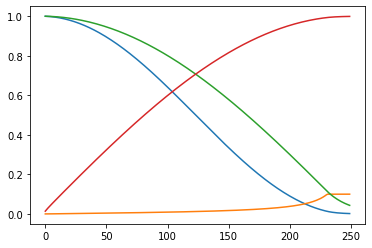

In [ ]:
plt.plot(alphas_), plt.plot(posterior_variance_corrected), plt.plot(jnp.sqrt(alphas_)), plt.plot(sd)

In [ ]:
#@title utils
# Various helper utility functions.

import io
import math
from IPython.display import display_png
import matplotlib as mpl
import matplotlib.cm as cm
from clu import deterministic_data

def imify(arr, vmin=None, vmax=None, cmap=None, origin=None):
  """Convert an array to an image.

  Arguments:
    arr : array-like The image data. The shape can be one of MxN (luminance),
      MxNx3 (RGB) or MxNx4 (RGBA).
    vmin : scalar, optional lower value.
    vmax : scalar, optional *vmin* and *vmax* set the color scaling for the
      image by fixing the values that map to the colormap color limits. If
      either *vmin* or *vmax* is None, that limit is determined from the *arr*
      min/max value.
    cmap : str or `~matplotlib.colors.Colormap`, optional A Colormap instance or
      registered colormap name. The colormap maps scalar data to colors. It is
      ignored for RGB(A) data.
        Defaults to :rc:`image.cmap` ('viridis').
    origin : {'upper', 'lower'}, optional Indicates whether the ``(0, 0)`` index
      of the array is in the upper
        left or lower left corner of the axes.  Defaults to :rc:`image.origin`
          ('upper').

  Returns:
    A uint8 image array.
  """
  sm = cm.ScalarMappable(cmap=cmap)
  sm.set_clim(vmin, vmax)
  if origin is None:
    origin = mpl.rcParams["image.origin"]
  if origin == "lower":
    arr = arr[::-1]
  rgba = sm.to_rgba(arr, bytes=True)
  return rgba

def rawarrview(array, **kwargs):
  """Visualize an array as if it was an image in colab notebooks.

  Arguments:
    array: an array which will be turned into an image.
    **kwargs: Additional keyword arguments passed to imify.
  """
  f = io.BytesIO()
  imarray = imify(array, **kwargs)
  plt.imsave(f, imarray, format="png")
  f.seek(0)
  dat = f.read()
  f.close()
  display_png(dat, raw=True)


def reshape_image_batch(array, cut=None, rows=None, axis=0):
  """Given an array of shape [n, x, y, ...] reshape it to create an image field.

  Arguments:
    array: The array to reshape.
    cut: Optional cut on the number of images to view. Will default to whole
      array.
    rows: Number of rows to use.  Will default to the integer less than the
      sqrt.
    axis: Axis to interpretate at the batch dimension.  By default the image
      dimensions immediately follow.

  Returns:
    reshaped_array: An array of shape [rows * x, cut / rows * y, ...]
  """
  original_shape = array.shape
  assert len(original_shape) >= 2, "array must be at least 3 Dimensional."

  if cut is None:
    cut = original_shape[axis]
  if rows is None:
    rows = int(math.sqrt(cut))

  cols = cut // rows
  cut = cols * rows

  leading = original_shape[:axis]
  x_width = original_shape[axis + 1]
  y_width = original_shape[axis + 2]
  remaining = original_shape[axis + 3:]

  array = array[:cut]
  array = array.reshape(leading + (rows, cols, x_width, y_width) + remaining)
  array = np.moveaxis(array, axis + 2, axis + 1)
  array = array.reshape(leading + (rows * x_width, cols * y_width) + remaining)
  return array

def zoom(im, k, axes=(0, 1)):
  for ax in axes:
    im = np.repeat(im, k, ax)
  return im


def imgviewer(im, zoom=3, cmap='bone_r', normalize=False, **kwargs):
  if normalize:
    im = im - im.min()
    im = im / im.max()
  return rawarrview(zoom(im, zoom), cmap=cmap, **kwargs)

# replicate = flax.jax_utils.replicate
# unreplicate = flax.jax_utils.unreplicate

In [ ]:
#@title data

dataset_builder = tfds.builder('emnist', data_dir=dataset_path)
dataset_builder.download_and_prepare()

train_split = tfds.split_for_jax_process('train+train', drop_remainder=True)

def preprocess_fn(example):
  image = tf.cast(example['image'], 'float32')
  image = tf.transpose(image, (1, 0, 2,))
  image = image / 255.0
  return (image, example["label"] + 1)

batch_size = 4 * 128
train_ds = deterministic_data.create_dataset(
    dataset_builder,
    split=train_split,
    rng=jax.random.PRNGKey(0),
    shuffle_buffer_size=100,
    batch_dims=[jax.local_device_count(), batch_size // jax.device_count()],
    num_epochs=None,
    preprocess_fn=lambda x: preprocess_fn(x),
    shuffle=True)

def create_input_iter(ds):
  def _prepare(xs):
    def _f(x):
      x = x._numpy()
      return x
    return jax.tree_util.tree_map(_f, xs)
  it = map(_prepare, ds)
  it = jax_utils.prefetch_to_device(it, 2)
  return it

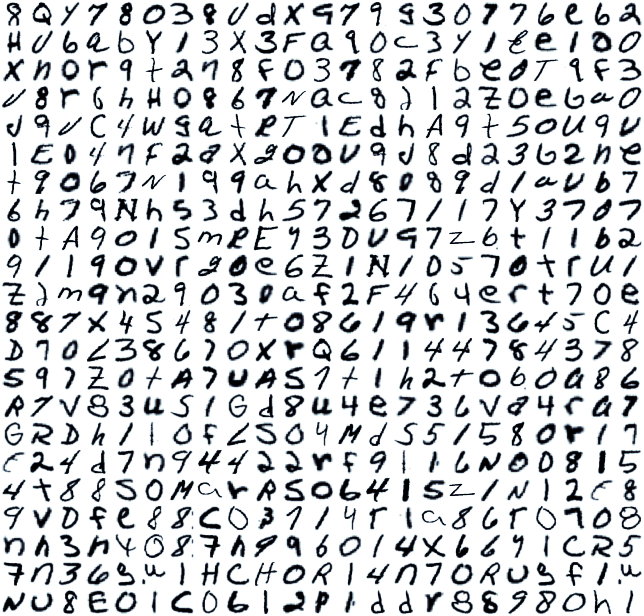

In [ ]:
out = next(create_input_iter(train_ds))
rawarrview(reshape_image_batch(out[0][0].squeeze()), cmap='bone_r')

In [ ]:
# adapted from Optax loss -- https://github.com/deepmind/optax/blob/master/optax/_src/loss.py
@jax.jit
def huber_loss(
    predictions,
    targets= None,
    delta= 1.):
  """Huber loss, similar to L2 loss close to zero, L1 loss away from zero.
  If gradient descent is applied to the `huber loss`, it is equivalent to
  clipping gradients of an `l2_loss` to `[-delta, delta]` in the backward pass.
  References:
    [Huber, 1964](www.projecteuclid.org/download/pdf_1/euclid.aoms/1177703732)
  Args:
    predictions: a vector of arbitrary shape `[...]`.
    targets: a vector with shape broadcastable to that of `predictions`;
      if not provided then it is assumed to be a vector of zeros.
    delta: the bounds for the huber loss transformation, defaults at 1.
  Returns:
    elementwise huber losses, with the same shape of `predictions`.
  """
  errors = (predictions - targets) if (targets is not None) else predictions
  # 0.5 * err^2                  if |err| <= d
  # 0.5 * d^2 + d * (|err| - d)  if |err| > d
  abs_errors = jnp.abs(errors)
  quadratic = jnp.minimum(abs_errors, delta)
  # Same as max(abs_x - delta, 0) but avoids potentially doubling gradient.
  linear = abs_errors - quadratic
  return jnp.sum(0.5 * quadratic ** 2 + delta * linear, axis=(1, 2, 3))

# Recommended: this can be jit'd and it should result in faster training time 
@jax.jit
def compute_loss(params: hk.Params, batch: Batch, is_energy_method: bool=False) -> jnp.ndarray:
  """Compute the loss of the network, including L2."""
  x, label, timestep, noise = batch
  pred_data = net.apply(params, x, timestep, label)
  
  def error_func():
    imp_weight = 1.0 # 1/2 * (1/sigma_squared_q_t_corrected[timestep]) * ((betas[timestep])**2 / (variance[timestep] * alphas[timestep]))
      # loss on prediction
    loss_ = jnp.sum(jnp.multiply(imp_weight, huber_loss(noise, pred_data)))
    return loss_
  
  def energy_func():
    ## Energy function interpretation
    imp_weight = 1.0 # 1/2 * (1/sigma_squared_q_t_corrected[timestep]) * ((betas[timestep])**2 / (alphas[timestep]))
    # loss on prediction
    loss_ = jnp.sum(jnp.multiply(imp_weight, huber_loss(pred_data, jnp.divide(noise, -sd[timestep]))))
    return loss_
    
  loss_ = jax.lax.cond(is_energy_method, energy_func, error_func)
  return loss_ 

@jax.jit
def update(
    params: hk.Params,
    opt_state: optax.OptState,
    batch: Batch,
    is_energy_method: bool=False
) -> Tuple[hk.Params, optax.OptState]:
  """Compute gradients and update the weights"""
  loss_value, grads = jax.value_and_grad(compute_loss)(params, batch, is_energy_method)
  updates, opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return loss_value, new_params, opt_state

@jax.jit
def ema_update(params, avg_params):
  """Incrementally update parameters via polyak averaging."""
  # Polyak averaging tracks an (exponential moving) average of the past parameters of a model, for use at test/evaluation time.
  return optax.incremental_update(params, avg_params, step_size=0.95)

@jax.jit
def unnormalize(images):
  return images*255.
  

In [ ]:
# using 20% of the dataset for training, 80% for validation, although it's weird to use maximum available data for validation
# BUG: using 80% train data, since performance improvement beyond 50% wasn't seen with 20% train data
# batch_size=512
# train = load_dataset("train+test", is_training=True, batch_size=batch_size)

In [ ]:
%%capture 
# % matplotlib inline 
# to discard cell output

import matplotlib.animation as animation
import imageio 
from IPython.display import Image
from matplotlib.pyplot import figure

random_index = 22
image = next(create_input_iter(train_ds))[0][0][random_index]
fig = plt.figure()
ims = []
noisy_images, _ = get_noisy(key, einops.repeat(image, 'h w c -> b h w c', b=timesteps//5), jnp.arange(1, timesteps, 5))
if colab:
  noisy_images = einops.rearrange(noisy_images, 'b h w c -> b h (w c)')
noisy_images = unnormalize(noisy_images)

for i in range(timesteps//10):
    im = plt.imshow(noisy_images[i], cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=5, blit=True, repeat_delay=3000)
animate.save(gifs_dir+'diffusion.gif', writer='pillow')

def show_image(img, plt_):
  figure(figsize=(2, 2))
  if colab:
    img = einops.rearrange(img, 'h w c -> h (w c)')
  plt_.imshow(img, cmap="gray", animated=False)

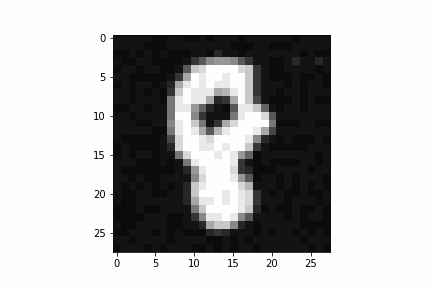

In [ ]:
with open(gifs_dir + 'diffusion.gif','rb') as f:
  display(Image(data=f.read(), format='png'))

In [ ]:
# upsample operation in the UNET
class Downsample(hk.Module):
  def __init__(self, output_channels):
    super().__init__()
    self.conv = hk.Conv2D(output_channels=output_channels, kernel_shape=(4, 4), stride=2, padding=[1, 1])
  
  def __call__(self, x):
    return self.conv(x)
  
# Downsample operation in the UNET
class Upsample(hk.Module):
  def __init__(self, output_channels):
    super().__init__()
    self.conv = hk.Conv2D(output_channels=output_channels, kernel_shape=(3, 3), padding='SAME')
  
  def __call__(self, x):
    # scaling image to twice size
    x = einops.repeat(x, 'b h w c -> b (a h) (aa w) c', a=2, aa=2)
    return self.conv(x)
      
class TimeEmbeddings(hk.Module):
  def __init__(self, dim):
    super().__init__()
    half_dim = dim // 2
    embeddings = math.log(10000) / (half_dim - 1)
    self.embeddings = jnp.exp(jnp.arange(half_dim) * -embeddings)

  def __call__(self, timesteps):
      embeddings = self.embeddings
      embeddings = jnp.multiply(timesteps[:, None], embeddings[:, None].T)
      embeddings = jnp.hstack([jnp.sin(embeddings), jnp.cos(embeddings)])
      return embeddings

class Block(hk.Module):
  # a basic resnet style convolutional block
  def __init__(self, output_channels, kernel_size, padding):
    super().__init__()
    self.proj = hk.Conv2D(output_channels=output_channels, kernel_shape=(kernel_size, kernel_size), padding='SAME')
    self.ln = hk.LayerNorm(axis=(-3, -2, -1), create_scale=True, create_offset=True)
    self.seq = hk.Sequential([
      jax.nn.silu,
      hk.Conv2D(output_channels=output_channels, kernel_shape=(kernel_size, kernel_size), padding='SAME'),
      hk.LayerNorm(axis=(-3, -2, -1), create_scale=True, create_offset=True),
      jax.nn.silu,
    ])
    self.out_conv = hk.Conv2D(output_channels=output_channels, kernel_shape=(1, 1), padding='SAME') 
    # self.time_mlp = None
    dims = output_channels
    self.time_mlp = hk.Sequential([
      jax.nn.silu,
      hk.Linear(dims*2),
    ])
    
  def __call__(self, x, timestep_embeddings=None):
    h = self.proj(x)
    h = self.ln(h)
    if timestep_embeddings is not None and self.time_mlp is not None:
      time_embedding = self.time_mlp(timestep_embeddings)
      time_embedding = einops.rearrange(time_embedding, 'b c -> b 1 1 c')
      shift, scale = jnp.split(time_embedding, indices_or_sections=2, axis=-1)
      h = shift + (scale+1)*h
    
    h = self.seq(h)
    return self.out_conv(x) + h

In [ ]:
# Unet class to predict noise from a given image
class UNet(hk.Module):
  def __init__(self):
    super().__init__()
    self.init_conv = hk.Conv2D(output_channels=48, kernel_shape = (5,5), padding='SAME')
    self.silu = jax.nn.silu
    self.block1 = Block(output_channels=48, kernel_size=3, padding=1)
    self.downsample1 = Downsample(96)
    self.block2 = Block(output_channels=96, kernel_size=3, padding=1)
    self.downsample2 = Downsample(192)
    self.middle_block = Block(output_channels=192, kernel_size=3, padding=1)
    self.upsample1 = Upsample(96)
    self.block3 = Block(output_channels=96, kernel_size=3, padding=1)
    self.upsample2 = Upsample(48)
    self.block4 = Block(output_channels=48, kernel_size=3, padding=1)
    self.seq = hk.Sequential([
        hk.Conv2D(output_channels=48, kernel_shape = (3,3), padding='SAME'),
        hk.LayerNorm(axis=(-3, -2, -1), create_scale=True, create_offset=True),
        jax.nn.silu,
        hk.Conv2D(output_channels=1, kernel_shape = (5,5), padding='SAME'),
    ])
    self.time_mlp = hk.Sequential([
      hk.Linear(256),
      jax.nn.gelu,
      hk.Linear(256),
    ])
    # conditional vectors encoding
    self.embedding_vectors = hk.Embed(10+26+26+1, 63)
    self.timestep_embeddings = TimeEmbeddings(96)
      
  def __call__(self, x, timesteps, cond=None):
    cond_embedding = None
    conditioning = None
    if timesteps is not None:
      timestep_embeddings = self.timestep_embeddings(timesteps)
      conditioning = timestep_embeddings
    if cond is not None:
      label_embeddings = self.embedding_vectors(cond)
      conditioning = jnp.concatenate([label_embeddings, conditioning], axis=1)
    if conditioning is not None:  
      cond_embedding = self.time_mlp(conditioning)
    h = self.init_conv(x)
    xx = jnp.copy(h)
    b1 = self.block1(self.silu(h), cond_embedding)
    h = self.downsample1(b1)
    b2 = self.block2(h, cond_embedding)
    h = self.downsample2(b2)
    h = self.upsample1(self.middle_block(h, cond_embedding))
    b3 = self.block3(jnp.concatenate((h, b2), axis=3), cond_embedding)
    h = self.upsample2(b3)
    b4 = self.block4(jnp.concatenate((h, b1), axis=3), cond_embedding)
    h = self.seq(jnp.concatenate((xx, b4), axis=3))
    return h

In [ ]:
def save(ckpt_dir: str, state, model_name) -> None:
  with open(os.path.join(ckpt_dir, model_name+"_arrays.npy"), "wb") as f:
    for x in jax.tree_util.tree_leaves(state):
         np.save(f, x, allow_pickle=False)
    tree_struct = jax.tree_map(lambda t: 0, state)
  with open(os.path.join(ckpt_dir, model_name+"_tree.pkl"), "wb") as f:
     pickle.dump(tree_struct, f)

def restore(ckpt_dir, model_name):
  with open(os.path.join(ckpt_dir, model_name+"_tree.pkl"), "rb") as f:
    tree_struct = pickle.load(f)
 
  leaves, treedef = jax.tree_util.tree_flatten(tree_struct)
  with open(os.path.join(ckpt_dir, model_name+"_arrays.npy"), "rb") as f:
    flat_state = [np.load(f) for _ in leaves]

  return jax.tree_util.tree_unflatten(treedef, flat_state)

def test_model_save():
  save('saved/saved_models/', avg_params, 'emnist_model')
  avg_params = restore('saved/saved_models/', 'emnist_model')

In [ ]:
import graphviz

def f(x, timesteps, label):
  unet = UNet()
  return unet(x, timesteps, label)

f_t = hk.transform(f)
net = hk.without_apply_rng(f_t)

image, label = next(create_input_iter(train_ds)) #jnp.ones([100, 28, 28, 1])
timesteps_ = jnp.arange(0, 10)

_, rng = jax.random.split(key)

if cont and os.path.exists(osp.join(model_paths, model_name + '_tree.pkl')):
  avg_params = restore(model_paths, model_name)
  params = deepcopy(avg_params)
else:
  params = net.init(rng, (image[0][0:10]), timesteps_, label[0][0:10])

# dot = hk.experimental.to_dot(f_t.apply)(params, None, x, timesteps)
# graphviz.Source(dot)

# print(hk.experimental.tabulate(f_t)(x, timesteps_))

opt = optax.adam(1e-3)

avg_params = deepcopy(params)
opt_state = opt.init(params)



---




### Training

In [ ]:
def show_predicted_image(noisy_image, params, timestep, label=None):
  print('time step for image', timestep)
  timestep = jnp.array([timestep])
  pred_noise = net.apply(params, noisy_image, timestep, label)
  pred_image = noisy_image/jnp.sqrt(alphas_[timestep]) - pred_noise*sd[timestep]/jnp.sqrt(alphas_[timestep])
  _, (p1, p2) = plt.subplots(1, 2)
  show_image(unnormalize(pred_image[0]), p1)
  show_image(unnormalize(noisy_image[0]), p2)
  plt.show()
  return huber_loss(noisy_image, pred_image)
  
# show random images
# show_predicted_image(x, avg_params, 10)

In [ ]:
b, l = image[0], label[0] # next(create_input_iter(train_ds))[0]

unique_key = jax.random.fold_in(key, jnp.sum(b))
_, *subkeys = jax.random.split(unique_key, timesteps)

time step for image 249


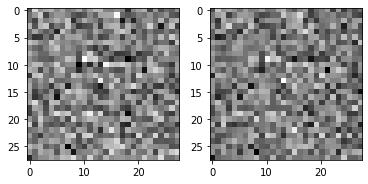

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

[16120.514]


In [ ]:
def test_loss_fn():
  loss_ = []
  huber_loss_ = []
  huber_loss_weighted = []
  imp_weight_ = []
  model_huber_loss = []
  for i in range(1, timesteps):
    tt = jnp.array([i])
    data_noisy_temp, noise_temp = get_noisy(subkeys[i-1], b, tt)
    loss_.append(jax.device_get(compute_loss(avg_params, [data_noisy_temp[0:1], l[0:1], tt, 
                                                          noise_temp[0:1]], False)))
    huber_loss__ = huber_loss(data_noisy_temp[0:2], b[0:2])
    huber_loss_.append(huber_loss__)
    
    imp_weight = 1/2 * (1/sigma_squared_q_t_corrected[tt]) * ((betas[tt])**2 / (variance[tt] * alphas[tt]))
    # loss on prediction
    huber_loss_weighted.append(jnp.sum(jnp.multiply(imp_weight, huber_loss__)))
    imp_weight_.append(imp_weight)
    
    pp = net.apply(avg_params, data_noisy_temp[0:1], tt, l[0:1])
    model_huber_loss.append(huber_loss(pp[0:1], noise_temp[0:1]))
    
  print(show_predicted_image(data_noisy_temp[0:1], avg_params, i, l[0:1]))
  return loss_, huber_loss_, huber_loss_weighted, imp_weight_, model_huber_loss
  
loss_, huber_loss_, huber_loss_weighted, imp_weight_, model_huber_loss = test_loss_fn()

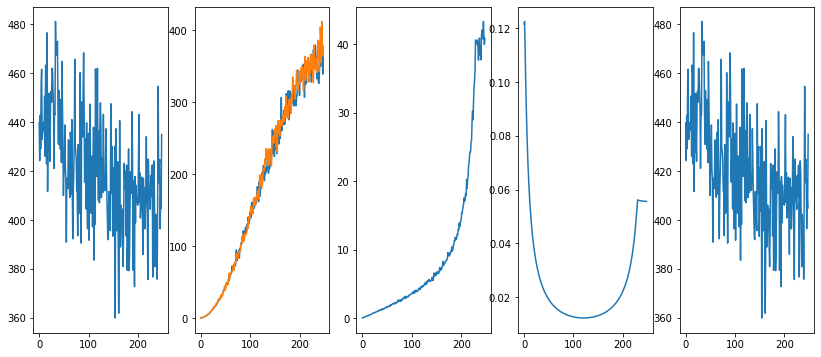

In [ ]:
_, (plt1, plt2, plt3, plt4, plt5) = plt.subplots(1,5, figsize=(14, 6))

plt1.plot(loss_)
plt2.plot(huber_loss_)
plt3.plot(huber_loss_weighted)
plt4.plot(imp_weight_)
plt5.plot(model_huber_loss)

In [ ]:
from copy import deepcopy
import pickle
import sys

batches_iter = 20000

def train_model(opt_state, params, avg_params, model_name, train_new_model=False, energy_method=False):
    best_loss = sys.float_info.max # initialization
    train = create_input_iter(train_ds)    

    if train_new_model or not os.path.exists(osp.join(data_paths, model_name + '_state.pt')):
        # generating sub keys for timesteps
        unique_key = jax.random.fold_in(key, batch_size)
        
        # same subkey being used for noise sampling, as it doesn't matter :)
        _, *timestep_subkeys = jax.random.split(unique_key, batches_iter+1)
        
        losses = []
        for iteration in range(0, batches_iter):
            data_in_batch, label = next(train)
            data_in_batch = data_in_batch[0]
            label = label[0]
            idx = (jax.random.uniform(key=timestep_subkeys[iteration], shape=(batch_size, 1)) * (timesteps-1)).astype(int)
            idx = einops.rearrange(idx, 'a b -> (a b)')
            timestep = idx + 1
            data_noisy, noise = get_noisy(timestep_subkeys[iteration], data_in_batch, timestep)
            # todo: call gradient update function here
            loss_value, params, opt_state = update(params, opt_state, [data_noisy, label, timestep, noise], energy_method)
            avg_params = ema_update(params, avg_params)
            
            if iteration % 10 == 0:
              print("batch loss value: ", loss_value)
            
            if iteration % 20 == 0:                
                ## evaluating noise on a fixed timestep to calculate best model
                one_timestep = jnp.mod(jnp.arange(1, batch_size+1), timesteps)
                data_noisy_temp, noise_temp = get_noisy(timestep_subkeys[iteration], data_in_batch, one_timestep)
                loss_temp = jax.device_get(compute_loss(avg_params, [data_noisy_temp, label, one_timestep, noise_temp], energy_method))
                losses.append(loss_temp)
            
                if loss_temp < best_loss:
                    best_loss = loss_temp
                    print(f"saving iteration: {iteration} loss: {best_loss:>7f}")
                    save(model_paths, avg_params, model_name)
                    write_cached([data_noisy, data_in_batch, timestep, losses], osp.join(data_paths, model_name + '_state.pt'))
            
                if iteration % 100 == 0:
                    print(f"iteration: {iteration} loss: {loss_temp:>7f}")
                    # sample a random number
                    r_ = (jax.random.uniform(timestep_subkeys[iteration])*batch_size).astype(int)
                    show_predicted_image(data_noisy_temp[r_: r_+1], avg_params, one_timestep[r_], label[r_: r_+1])

    if os.path.exists(osp.join(data_paths, model_name + '_state.pt')):
        avg_params = restore(model_paths, model_name)
        params = deepcopy(avg_params)
        data_noisy, data_in_batch, timestep, losses = load_cached(osp.join(data_paths, model_name + '_state.pt')) 
    return data_noisy, data_in_batch, timestep, losses, avg_params

batch loss value:  216321.5
saving iteration: 0 loss: 454390.531250
iteration: 0 loss: 454390.531250
time step for image 12


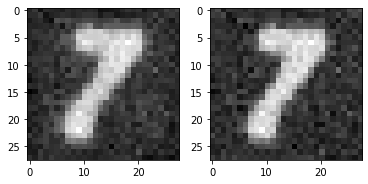

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  167830.8
batch loss value:  103650.625
saving iteration: 20 loss: 66746.203125
batch loss value:  84051.53
batch loss value:  38515.543
saving iteration: 40 loss: 41308.312500
batch loss value:  30678.39
batch loss value:  28301.914
saving iteration: 60 loss: 29526.806641
batch loss value:  24306.8
batch loss value:  20520.617
saving iteration: 80 loss: 23499.027344
batch loss value:  20014.527
batch loss value:  17689.043
saving iteration: 100 loss: 20430.451172
iteration: 100 loss: 20430.451172
time step for image 123


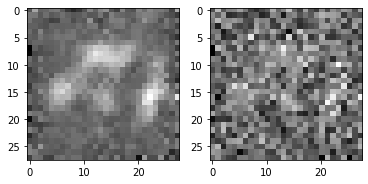

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  17737.418
batch loss value:  15979.171
saving iteration: 120 loss: 18401.250000
batch loss value:  17756.068
batch loss value:  14371.6875
saving iteration: 140 loss: 17046.755859
batch loss value:  14893.634
batch loss value:  14487.936
saving iteration: 160 loss: 15536.975586
batch loss value:  13151.535
batch loss value:  13605.647
saving iteration: 180 loss: 14766.122070
batch loss value:  12775.503
batch loss value:  11806.164
saving iteration: 200 loss: 14131.204102
iteration: 200 loss: 14131.204102
time step for image 74


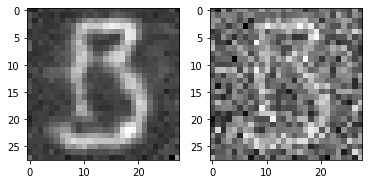

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  13143.958
batch loss value:  12117.227
saving iteration: 220 loss: 13303.798828
batch loss value:  12510.443
batch loss value:  11401.178
saving iteration: 240 loss: 12194.351562
batch loss value:  10800.373
batch loss value:  10408.961
saving iteration: 260 loss: 11454.747070
batch loss value:  10238.615
batch loss value:  10573.003
batch loss value:  10639.792
batch loss value:  10042.162
saving iteration: 300 loss: 11408.899414
iteration: 300 loss: 11408.899414
time step for image 221


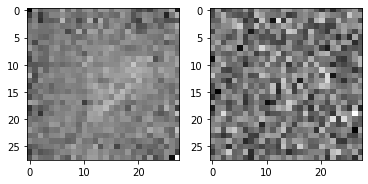

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  9729.142
batch loss value:  9720.568
saving iteration: 320 loss: 11203.308594
batch loss value:  9275.296
batch loss value:  9061.725
saving iteration: 340 loss: 10869.640625
batch loss value:  9822.466
batch loss value:  9270.316
saving iteration: 360 loss: 9997.400391
batch loss value:  9277.214
batch loss value:  9246.06
saving iteration: 380 loss: 9954.675781
batch loss value:  8136.3853
batch loss value:  8840.239
saving iteration: 400 loss: 9921.304688
iteration: 400 loss: 9921.304688
time step for image 83


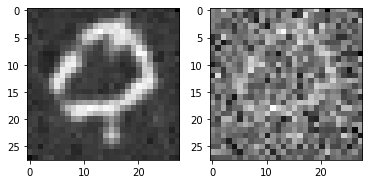

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  8831.895
batch loss value:  8991.361
batch loss value:  9320.035
batch loss value:  7871.0547
saving iteration: 440 loss: 9509.320312
batch loss value:  8396.192
batch loss value:  8391.357
saving iteration: 460 loss: 9454.052734
batch loss value:  8661.804
batch loss value:  8696.353
saving iteration: 480 loss: 9235.122070
batch loss value:  8070.74
batch loss value:  8056.1133
saving iteration: 500 loss: 9098.640625
iteration: 500 loss: 9098.640625
time step for image 100


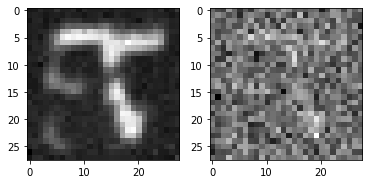

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  8266.078
batch loss value:  8558.131
saving iteration: 520 loss: 8972.315430
batch loss value:  8559.656
batch loss value:  7953.255
batch loss value:  7871.5107
batch loss value:  8360.403
batch loss value:  7876.088
batch loss value:  8639.323
saving iteration: 580 loss: 8835.341797
batch loss value:  8122.376
batch loss value:  8051.0244
saving iteration: 600 loss: 8636.837891
iteration: 600 loss: 8636.837891
time step for image 56


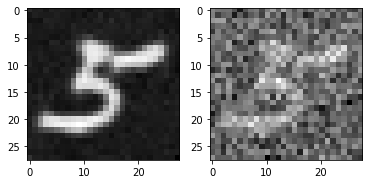

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  7777.2847
batch loss value:  7091.247
saving iteration: 620 loss: 8597.583984
batch loss value:  7577.6445
batch loss value:  8026.168
saving iteration: 640 loss: 8409.284180
batch loss value:  7494.198
batch loss value:  7701.5444
batch loss value:  7593.8643
batch loss value:  7515.4565
saving iteration: 680 loss: 8179.986816
batch loss value:  7243.9346
batch loss value:  8424.224
iteration: 700 loss: 8550.965820
time step for image 0


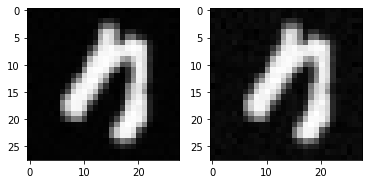

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  7758.92
batch loss value:  8131.5933
batch loss value:  7557.0225
batch loss value:  7327.5977
batch loss value:  7740.2607
batch loss value:  7420.334
saving iteration: 760 loss: 8176.839844
batch loss value:  7976.0347
batch loss value:  7991.5933
saving iteration: 780 loss: 8157.970703
batch loss value:  6714.6562
batch loss value:  7945.3804
saving iteration: 800 loss: 8145.090820
iteration: 800 loss: 8145.090820
time step for image 173


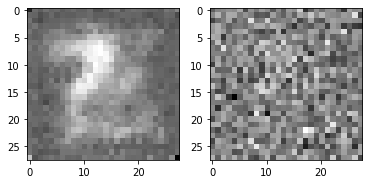

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  7158.5776
batch loss value:  7241.4766
saving iteration: 820 loss: 7884.841797
batch loss value:  7742.544
batch loss value:  6703.5483
batch loss value:  7976.6143
batch loss value:  7275.259
batch loss value:  7015.705
batch loss value:  7070.7305
batch loss value:  7617.082
batch loss value:  6519.9424
iteration: 900 loss: 7938.982422
time step for image 165


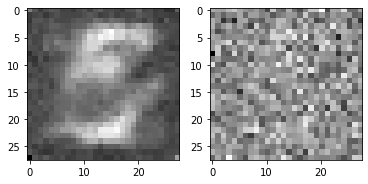

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  6700.166
batch loss value:  7182.3037
batch loss value:  6955.434
batch loss value:  7264.5967
saving iteration: 940 loss: 7876.488281
batch loss value:  6984.33
batch loss value:  7317.7046
batch loss value:  6118.714
batch loss value:  6784.3037
saving iteration: 980 loss: 7788.329102
batch loss value:  6633.548
batch loss value:  7400.3735
saving iteration: 1000 loss: 7642.659668
iteration: 1000 loss: 7642.659668
time step for image 201


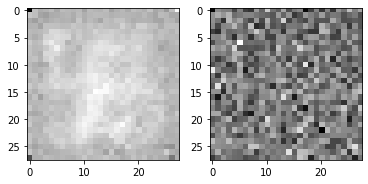

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  7153.8335
batch loss value:  6946.537
batch loss value:  7429.638
batch loss value:  6551.922
batch loss value:  6774.301
batch loss value:  6883.233
batch loss value:  6995.8105
batch loss value:  6415.6943
saving iteration: 1080 loss: 7507.183105
batch loss value:  7090.8423
batch loss value:  7287.9243
iteration: 1100 loss: 7668.905273
time step for image 209


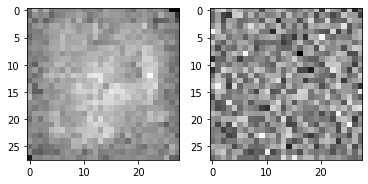

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  6867.7705
batch loss value:  6845.1245
batch loss value:  6954.1436
batch loss value:  6900.8916
saving iteration: 1140 loss: 7466.831543
batch loss value:  6594.332
batch loss value:  6954.5273
saving iteration: 1160 loss: 7368.393555
batch loss value:  6837.6963
batch loss value:  7420.1885
batch loss value:  6976.1914
batch loss value:  7384.1997
iteration: 1200 loss: 7736.216309
time step for image 23


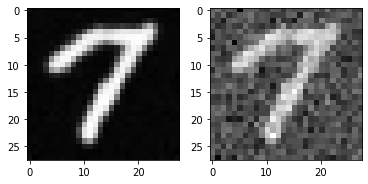

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  6875.1904
batch loss value:  6950.38
batch loss value:  6991.258
batch loss value:  7045.3706
batch loss value:  7173.871
batch loss value:  6801.2866
batch loss value:  7103.923
batch loss value:  6462.4014
batch loss value:  6152.978
batch loss value:  6078.259
saving iteration: 1300 loss: 7294.744629
iteration: 1300 loss: 7294.744629
time step for image 120


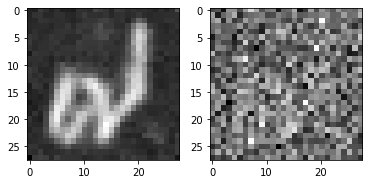

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  7104.8086
batch loss value:  6662.0205
saving iteration: 1320 loss: 7278.182617
batch loss value:  6590.6855
batch loss value:  6738.703
batch loss value:  6861.4624
batch loss value:  7284.2344
batch loss value:  6613.077
batch loss value:  7073.412
batch loss value:  6520.164
batch loss value:  6347.2573
saving iteration: 1400 loss: 7171.930664
iteration: 1400 loss: 7171.930664
time step for image 232


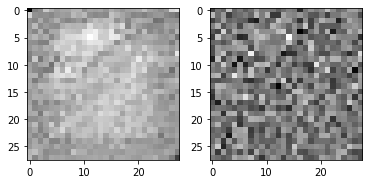

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  6548.42
batch loss value:  6811.7007
batch loss value:  7163.74
batch loss value:  6622.856
batch loss value:  7155.709
batch loss value:  6520.3057
batch loss value:  6942.0996
batch loss value:  6267.0005
saving iteration: 1480 loss: 6926.123047
batch loss value:  7488.787
batch loss value:  7661.0664
iteration: 1500 loss: 7610.438477
time step for image 188


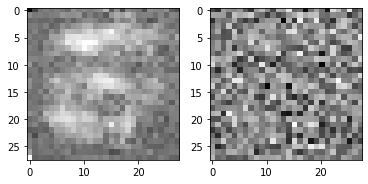

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  7049.277
batch loss value:  6806.6367
batch loss value:  6079.424
batch loss value:  6301.4067
batch loss value:  6642.7783
batch loss value:  6549.4785
batch loss value:  6339.321
batch loss value:  6500.647
batch loss value:  6258.198
batch loss value:  6303.517
iteration: 1600 loss: 7176.847656
time step for image 139


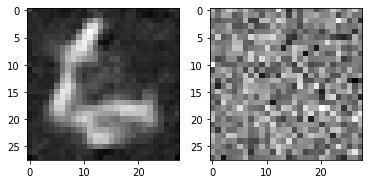

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  6807.6807
batch loss value:  6582.551
batch loss value:  6459.641
batch loss value:  5993.858
batch loss value:  6798.564
batch loss value:  6584.046
batch loss value:  5916.622
batch loss value:  6384.91
batch loss value:  6570.673
batch loss value:  5964.3936
iteration: 1700 loss: 7229.222656
time step for image 112


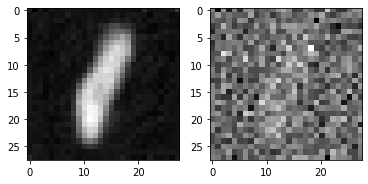

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5753.542
batch loss value:  6184.271
batch loss value:  6473.023
batch loss value:  6708.093
batch loss value:  6873.6855
batch loss value:  6842.588
batch loss value:  6291.5566
batch loss value:  6237.611
batch loss value:  6629.9917
batch loss value:  7109.319
iteration: 1800 loss: 7251.139648
time step for image 21


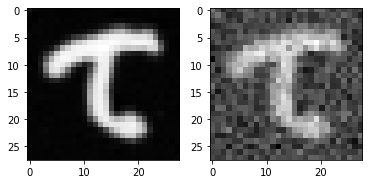

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  7117.96
batch loss value:  6646.211
batch loss value:  6191.6494
batch loss value:  6623.902
batch loss value:  6960.211
batch loss value:  6701.7217
saving iteration: 1860 loss: 6880.657227
batch loss value:  6285.9614
batch loss value:  6768.654
saving iteration: 1880 loss: 6818.962891
batch loss value:  6721.089
batch loss value:  6085.241
iteration: 1900 loss: 7101.502930
time step for image 175


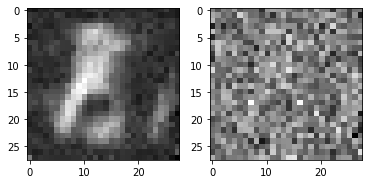

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  6210.967
batch loss value:  6326.7627
batch loss value:  5585.3574
batch loss value:  6068.4795
batch loss value:  6365.119
batch loss value:  6654.2583
batch loss value:  6705.6914
batch loss value:  5948.4507
batch loss value:  6203.329
batch loss value:  5999.3457
iteration: 2000 loss: 6896.449219
time step for image 124


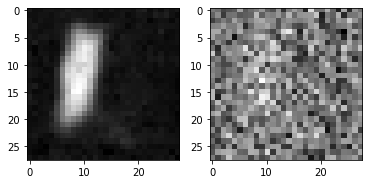

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  6265.061
batch loss value:  6357.382
batch loss value:  6364.8257
batch loss value:  6554.6064
batch loss value:  5989.3936
batch loss value:  6750.1143
batch loss value:  6486.3467
batch loss value:  6594.3877
batch loss value:  6091.9995
batch loss value:  6461.2256
iteration: 2100 loss: 7088.865234
time step for image 130


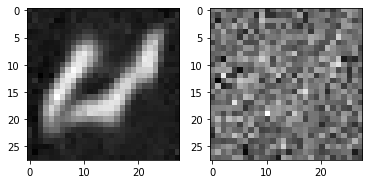

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  6051.3027
batch loss value:  6109.4556
batch loss value:  6599.285
batch loss value:  6147.5923
batch loss value:  6578.706
batch loss value:  6169.3965
batch loss value:  6560.254
batch loss value:  6259.742
batch loss value:  6650.4053
batch loss value:  6024.412
saving iteration: 2200 loss: 6774.648438
iteration: 2200 loss: 6774.648438
time step for image 34


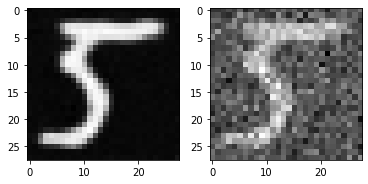

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  6522.5835
batch loss value:  6026.8438
saving iteration: 2220 loss: 6600.500977
batch loss value:  6072.2773
batch loss value:  5846.01
batch loss value:  6100.078
batch loss value:  6004.829
batch loss value:  5933.5723
batch loss value:  6543.5938
batch loss value:  6309.3447
batch loss value:  5931.8994
iteration: 2300 loss: 6813.821777
time step for image 196


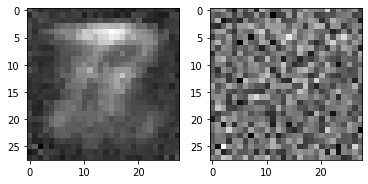

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  6122.0894
batch loss value:  6075.5522
batch loss value:  6355.5513
batch loss value:  6537.423
batch loss value:  6416.6797
batch loss value:  6573.7427
batch loss value:  6231.5244
batch loss value:  6270.961
batch loss value:  6554.257
batch loss value:  6410.717
iteration: 2400 loss: 6792.039062
time step for image 111


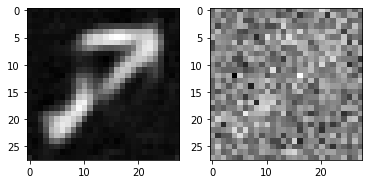

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  6073.4023
batch loss value:  5852.0903
batch loss value:  5808.102
batch loss value:  6157.6377
batch loss value:  5908.2637
batch loss value:  5995.949
batch loss value:  6016.969
batch loss value:  5536.6836
batch loss value:  6031.9434
batch loss value:  6385.711
iteration: 2500 loss: 6749.606445
time step for image 125


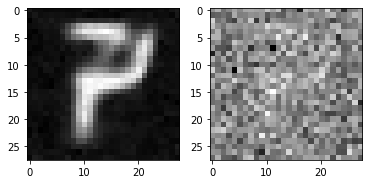

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  6251.365
batch loss value:  6146.5635
saving iteration: 2520 loss: 6590.579102
batch loss value:  6363.576
batch loss value:  6505.5195
batch loss value:  6147.7354
batch loss value:  6343.7656
batch loss value:  6205.3027
batch loss value:  5981.629
batch loss value:  6149.54
batch loss value:  5810.5176
iteration: 2600 loss: 6663.107422
time step for image 42


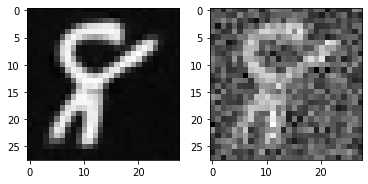

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  6470.755
batch loss value:  6199.283
batch loss value:  6579.499
batch loss value:  6471.7637
batch loss value:  5647.1147
batch loss value:  6562.1914
batch loss value:  5670.837
batch loss value:  6101.4756
saving iteration: 2680 loss: 6439.141113
batch loss value:  5847.5264
batch loss value:  6132.532
iteration: 2700 loss: 6825.857422
time step for image 150


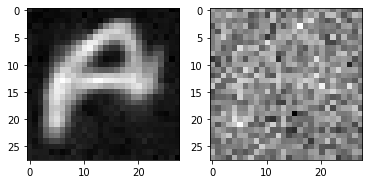

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5951.9014
batch loss value:  6022.513
batch loss value:  6236.402
batch loss value:  6299.721
batch loss value:  5765.1143
batch loss value:  6348.408
batch loss value:  6451.417
batch loss value:  6203.2114
batch loss value:  6147.0215
batch loss value:  5730.9795
iteration: 2800 loss: 6617.781250
time step for image 122


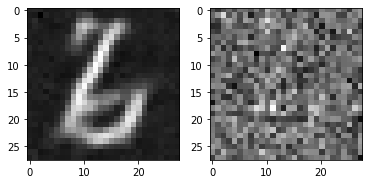

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  6233.7603
batch loss value:  5497.06
batch loss value:  6652.921
batch loss value:  6555.8164
batch loss value:  5726.595
batch loss value:  6036.211
batch loss value:  5629.257
batch loss value:  5853.681
batch loss value:  6024.248
batch loss value:  5772.9453
iteration: 2900 loss: 6712.701172
time step for image 224


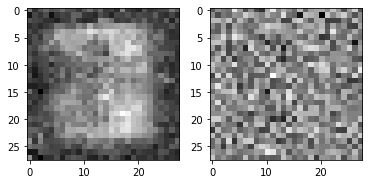

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  6390.5586
batch loss value:  5949.344
batch loss value:  6344.105
batch loss value:  5887.8833
batch loss value:  6068.212
batch loss value:  6147.0767
batch loss value:  6232.8594
batch loss value:  5721.989
batch loss value:  6297.998
batch loss value:  6239.6367
iteration: 3000 loss: 6779.187500
time step for image 4


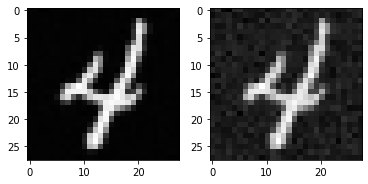

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  6051.573
batch loss value:  5771.6025
batch loss value:  6099.367
batch loss value:  5816.001
batch loss value:  5782.091
batch loss value:  5883.323
batch loss value:  5441.952
batch loss value:  6037.9844
saving iteration: 3080 loss: 6423.395020
batch loss value:  6117.919
batch loss value:  6111.934
iteration: 3100 loss: 6490.567383
time step for image 111


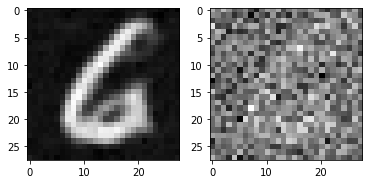

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5732.1475
batch loss value:  6583.1694
batch loss value:  6180.4688
batch loss value:  6186.321
batch loss value:  5671.521
batch loss value:  5977.8813
batch loss value:  6401.027
batch loss value:  5244.4136
batch loss value:  5767.381
batch loss value:  5695.1333
iteration: 3200 loss: 6690.390625
time step for image 151


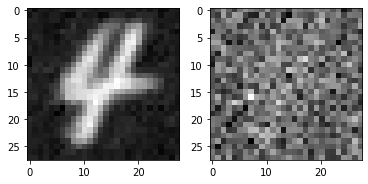

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  6120.917
batch loss value:  5898.7637
batch loss value:  5688.6436
batch loss value:  5871.194
saving iteration: 3240 loss: 6404.487793
batch loss value:  5524.813
batch loss value:  5697.7637
saving iteration: 3260 loss: 6225.171875
batch loss value:  5677.938
batch loss value:  5938.0557
batch loss value:  5695.246
batch loss value:  5808.871
iteration: 3300 loss: 6269.661133
time step for image 22


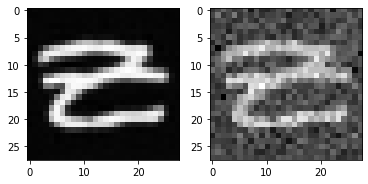

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5896.2754
batch loss value:  6043.0503
batch loss value:  5865.3613
batch loss value:  5756.121
batch loss value:  6074.163
batch loss value:  5915.0947
batch loss value:  6140.2803
batch loss value:  6040.2573
batch loss value:  6491.7637
batch loss value:  6057.2266
iteration: 3400 loss: 6611.358398
time step for image 201


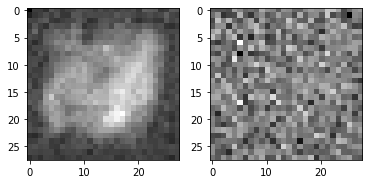

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5645.216
batch loss value:  5795.592
batch loss value:  5626.3047
batch loss value:  6344.4927
batch loss value:  5990.0586
batch loss value:  5771.9263
batch loss value:  5584.3447
batch loss value:  5716.5527
saving iteration: 3480 loss: 6144.770020
batch loss value:  5681.961
batch loss value:  5772.4814
iteration: 3500 loss: 6288.435059
time step for image 8


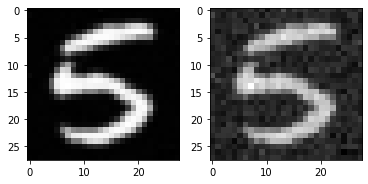

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5608.0107
batch loss value:  5737.3125
batch loss value:  5540.9736
batch loss value:  5690.5073
batch loss value:  5638.5293
batch loss value:  5703.3433
batch loss value:  5987.1797
batch loss value:  5810.64
batch loss value:  6336.7485
batch loss value:  5967.3364
iteration: 3600 loss: 6514.662109
time step for image 5


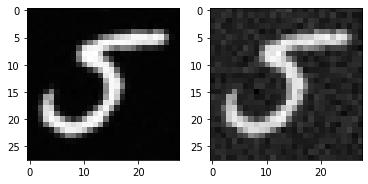

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5386.7017
batch loss value:  5837.888
batch loss value:  6048.917
batch loss value:  5741.533
batch loss value:  6107.4434
batch loss value:  6305.7686
batch loss value:  5677.909
batch loss value:  5936.58
batch loss value:  6002.217
batch loss value:  5867.751
iteration: 3700 loss: 6252.617188
time step for image 172


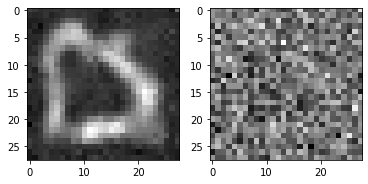

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5886.4756
batch loss value:  5376.204
batch loss value:  6014.192
batch loss value:  5662.9375
batch loss value:  5906.867
batch loss value:  5853.2236
batch loss value:  5298.418
batch loss value:  5986.539
batch loss value:  6146.037
batch loss value:  5910.1436
iteration: 3800 loss: 6391.892578
time step for image 66


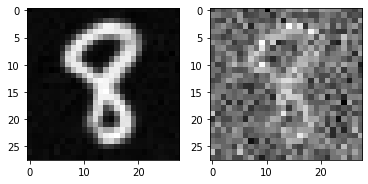

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5696.257
batch loss value:  5388.4883
batch loss value:  5833.764
batch loss value:  6127.3936
batch loss value:  5956.644
batch loss value:  5330.0146
batch loss value:  6248.667
batch loss value:  5661.85
batch loss value:  5935.4805
batch loss value:  5927.623
iteration: 3900 loss: 6185.453613
time step for image 54


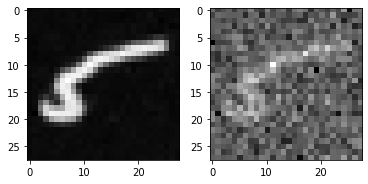

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5701.6074
batch loss value:  5498.2046
batch loss value:  5610.4795
batch loss value:  5955.2773
batch loss value:  6228.8164
batch loss value:  6142.492
batch loss value:  5965.8633
batch loss value:  5143.4077
batch loss value:  6006.633
batch loss value:  5449.92
iteration: 4000 loss: 6313.572266
time step for image 242


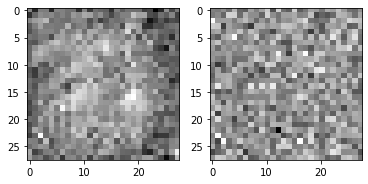

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5937.3994
batch loss value:  5637.921
batch loss value:  5431.0894
batch loss value:  5139.6816
saving iteration: 4040 loss: 5887.641113
batch loss value:  6023.414
batch loss value:  5873.6543
batch loss value:  5894.6855
batch loss value:  6016.493
batch loss value:  5971.406
batch loss value:  6038.127
iteration: 4100 loss: 6312.550293
time step for image 61


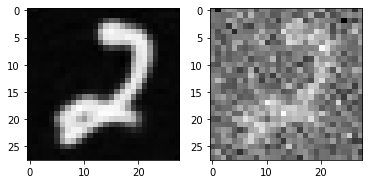

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5612.0767
batch loss value:  5628.9824
batch loss value:  5517.538
batch loss value:  5786.826
batch loss value:  6667.5547
batch loss value:  5723.9277
batch loss value:  5481.4785
batch loss value:  5301.118
batch loss value:  6093.536
batch loss value:  5910.2656
iteration: 4200 loss: 6181.996094
time step for image 164


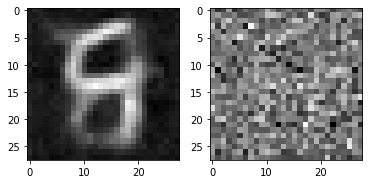

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5439.662
batch loss value:  5859.833
batch loss value:  5810.294
batch loss value:  5747.576
batch loss value:  5757.251
batch loss value:  5552.579
batch loss value:  5761.039
batch loss value:  5597.302
batch loss value:  5624.251
batch loss value:  5688.6377
iteration: 4300 loss: 6287.080078
time step for image 161


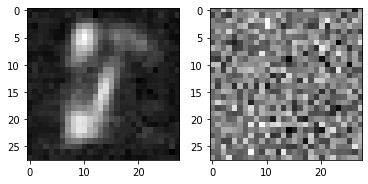

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5577.9556
batch loss value:  5497.151
batch loss value:  5796.798
batch loss value:  5531.3384
batch loss value:  5843.274
batch loss value:  5444.081
batch loss value:  5788.9995
batch loss value:  5335.5957
batch loss value:  5654.9756
batch loss value:  5465.251
iteration: 4400 loss: 6230.265137
time step for image 96


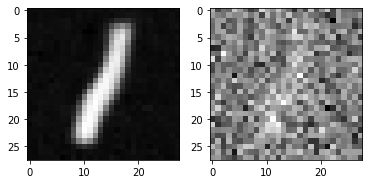

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  6107.198
batch loss value:  5673.3574
batch loss value:  5825.8594
batch loss value:  5680.338
batch loss value:  5213.9614
batch loss value:  5729.5107
batch loss value:  5757.4766
batch loss value:  5407.609
batch loss value:  5444.853
batch loss value:  5230.835
iteration: 4500 loss: 6152.877441
time step for image 133


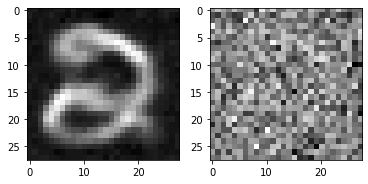

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5890.603
batch loss value:  5614.8174
batch loss value:  5775.3486
batch loss value:  6004.338
batch loss value:  5571.288
batch loss value:  5211.796
batch loss value:  5182.998
batch loss value:  5386.6455
batch loss value:  5910.926
batch loss value:  5729.0703
iteration: 4600 loss: 6368.937012
time step for image 140


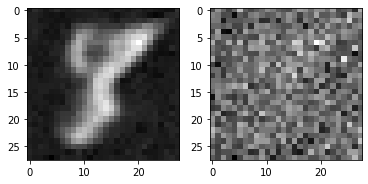

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5884.414
batch loss value:  5721.452
batch loss value:  5331.045
batch loss value:  5211.7266
batch loss value:  4964.7363
batch loss value:  5829.8936
batch loss value:  5573.333
batch loss value:  5121.974
batch loss value:  5713.5225
batch loss value:  5753.914
iteration: 4700 loss: 6419.058594
time step for image 217


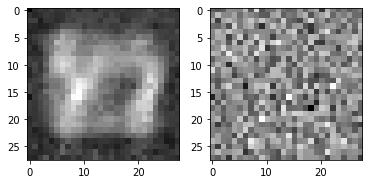

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5710.62
batch loss value:  5634.0737
batch loss value:  5492.389
batch loss value:  5307.8784
batch loss value:  6071.818
batch loss value:  5501.5205
batch loss value:  5256.8184
batch loss value:  5709.037
batch loss value:  6006.703
batch loss value:  5366.1304
iteration: 4800 loss: 6139.665527
time step for image 186


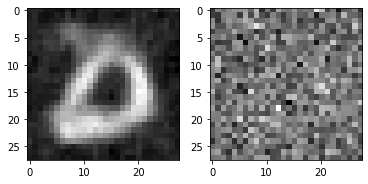

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5083.738
batch loss value:  5739.543
batch loss value:  5920.9243
batch loss value:  5428.259
batch loss value:  5811.2725
batch loss value:  5220.438
batch loss value:  5672.686
batch loss value:  5556.17
batch loss value:  5931.242
batch loss value:  5688.3057
iteration: 4900 loss: 6046.687500
time step for image 121


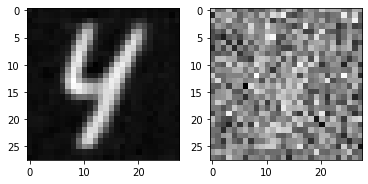

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  6047.318
batch loss value:  5810.672
batch loss value:  5820.038
batch loss value:  5805.889
batch loss value:  4890.6387
batch loss value:  5528.2725
batch loss value:  5545.7754
batch loss value:  5370.3896
batch loss value:  5963.9287
batch loss value:  5482.165
iteration: 5000 loss: 6167.607422
time step for image 187


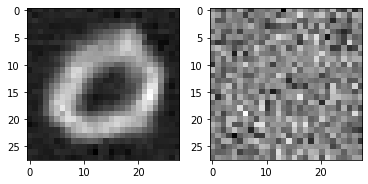

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5863.373
batch loss value:  5460.177
batch loss value:  5432.9287
batch loss value:  6045.8486
batch loss value:  5749.9287
batch loss value:  5470.8057
batch loss value:  5611.9497
batch loss value:  5341.111
batch loss value:  5649.168
batch loss value:  5240.2173
iteration: 5100 loss: 6194.485352
time step for image 36


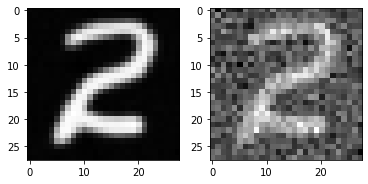

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5301.834
batch loss value:  6064.648
batch loss value:  5338.324
batch loss value:  5752.9297
batch loss value:  5894.838
batch loss value:  5753.603
batch loss value:  5381.0947
batch loss value:  4987.117
batch loss value:  5602.367
batch loss value:  5523.963
iteration: 5200 loss: 6107.063477
time step for image 157


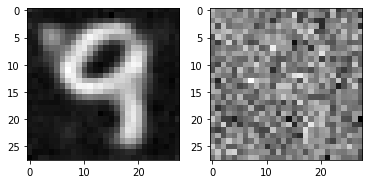

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5684.321
batch loss value:  5150.4116
batch loss value:  5490.3164
batch loss value:  5525.9697
batch loss value:  5511.9004
batch loss value:  5675.185
batch loss value:  5755.303
batch loss value:  5461.1396
batch loss value:  5267.039
batch loss value:  5411.4688
saving iteration: 5300 loss: 5868.731445
iteration: 5300 loss: 5868.731445
time step for image 11


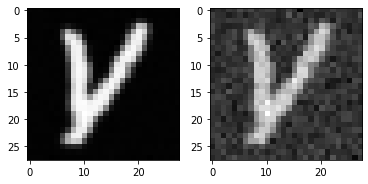

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5266.0586
batch loss value:  5519.8345
batch loss value:  5116.577
batch loss value:  5764.251
batch loss value:  5039.176
batch loss value:  5635.6445
batch loss value:  5152.161
batch loss value:  5668.635
batch loss value:  5040.704
batch loss value:  5399.8613
iteration: 5400 loss: 6195.000000
time step for image 235


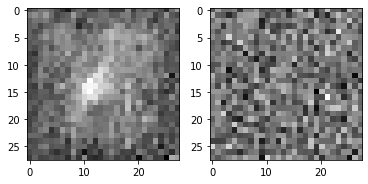

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5757.4097
batch loss value:  6060.425
saving iteration: 5420 loss: 5861.799805
batch loss value:  5566.646
batch loss value:  5289.343
batch loss value:  4998.7803
batch loss value:  5912.397
batch loss value:  5735.0796
batch loss value:  6076.4443
batch loss value:  5640.987
batch loss value:  5311.9004
iteration: 5500 loss: 5974.940918
time step for image 7


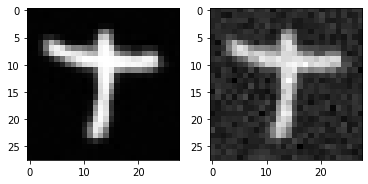

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5321.368
batch loss value:  6155.951
batch loss value:  5315.445
batch loss value:  5306.026
batch loss value:  5533.253
batch loss value:  5837.926
batch loss value:  5176.1772
batch loss value:  5419.1484
batch loss value:  5423.79
batch loss value:  5575.4546
iteration: 5600 loss: 6019.389648
time step for image 96


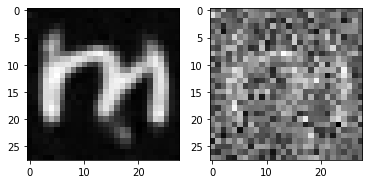

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5300.535
batch loss value:  6030.7524
batch loss value:  5463.928
batch loss value:  5788.589
batch loss value:  5522.9907
batch loss value:  5939.1963
batch loss value:  5212.6562
batch loss value:  5369.389
batch loss value:  5465.5303
batch loss value:  4944.7383
iteration: 5700 loss: 5947.823730
time step for image 204


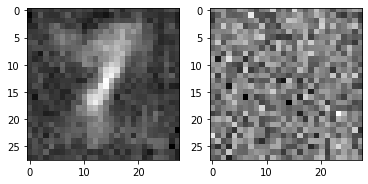

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5003.347
batch loss value:  6150.807
batch loss value:  6064.5625
batch loss value:  5440.186
batch loss value:  5627.881
batch loss value:  5435.5996
batch loss value:  5318.653
batch loss value:  5825.3604
saving iteration: 5780 loss: 5850.230469
batch loss value:  5524.273
batch loss value:  5631.997
iteration: 5800 loss: 6116.094727
time step for image 50


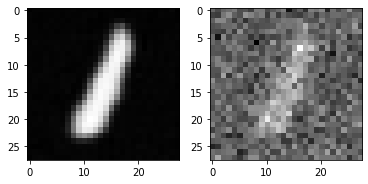

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5274.9453
batch loss value:  5522.423
batch loss value:  5773.432
batch loss value:  5234.1113
saving iteration: 5840 loss: 5660.206055
batch loss value:  5424.0327
batch loss value:  5552.5635
batch loss value:  5383.216
batch loss value:  4984.606
batch loss value:  5251.2173
batch loss value:  5950.3677
iteration: 5900 loss: 6018.710449
time step for image 62


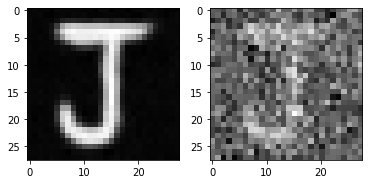

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5403.892
batch loss value:  5312.091
batch loss value:  5628.556
batch loss value:  5909.247
batch loss value:  5400.2217
batch loss value:  5599.842
batch loss value:  5514.43
batch loss value:  5505.482
batch loss value:  5637.0215
batch loss value:  5205.466
iteration: 6000 loss: 6194.233887
time step for image 49


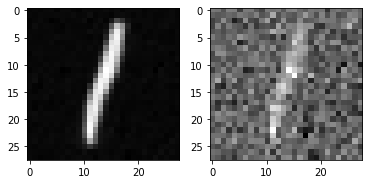

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5319.4507
batch loss value:  5437.0093
batch loss value:  5252.4297
batch loss value:  5235.25
batch loss value:  4778.8447
batch loss value:  5175.407
batch loss value:  5075.63
batch loss value:  5444.715
batch loss value:  5564.265
batch loss value:  5389.946
iteration: 6100 loss: 6025.209473
time step for image 36


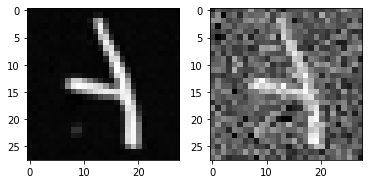

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5477.0776
batch loss value:  5445.4033
batch loss value:  5500.271
batch loss value:  5228.573
batch loss value:  5353.366
batch loss value:  5928.258
batch loss value:  5712.8643
batch loss value:  5576.8486
batch loss value:  4885.041
batch loss value:  5138.448
iteration: 6200 loss: 5803.941406
time step for image 239


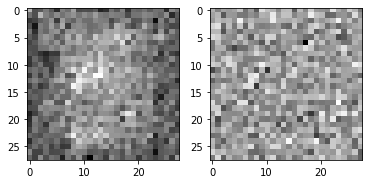

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5093.907
batch loss value:  5251.3228
batch loss value:  5742.127
batch loss value:  5457.818
batch loss value:  5163.285
batch loss value:  5213.298
batch loss value:  5176.929
batch loss value:  5141.6895
batch loss value:  5485.623
batch loss value:  4812.27
saving iteration: 6300 loss: 5479.796387
iteration: 6300 loss: 5479.796387
time step for image 157


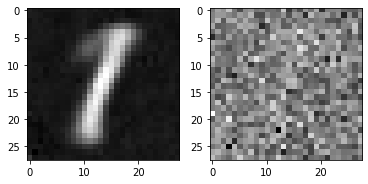

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4862.3936
batch loss value:  5166.057
batch loss value:  5433.5195
batch loss value:  4777.364
batch loss value:  5487.203
batch loss value:  5647.7676
batch loss value:  5285.4443
batch loss value:  5549.542
batch loss value:  5247.2275
batch loss value:  5146.121
iteration: 6400 loss: 5731.958008
time step for image 191


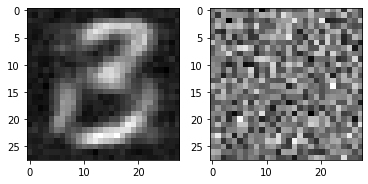

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5271.9795
batch loss value:  5446.2305
batch loss value:  5606.9883
batch loss value:  5577.2285
batch loss value:  5329.539
batch loss value:  5306.2646
batch loss value:  5720.359
batch loss value:  5051.049
batch loss value:  4874.7783
batch loss value:  5052.161
iteration: 6500 loss: 5755.133789
time step for image 52


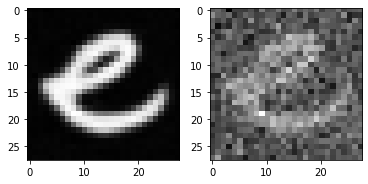

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5273.268
batch loss value:  5031.451
batch loss value:  5890.3496
batch loss value:  4961.1187
batch loss value:  5142.0547
batch loss value:  5209.1406
batch loss value:  5425.421
batch loss value:  5456.3066
batch loss value:  5926.813
batch loss value:  5042.5312
iteration: 6600 loss: 5697.902832
time step for image 30


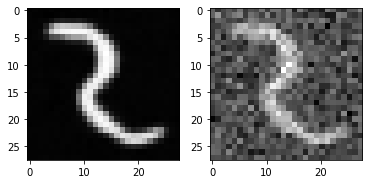

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5626.0264
batch loss value:  5533.744
batch loss value:  4879.5596
batch loss value:  5397.9355
batch loss value:  5414.3896
batch loss value:  5092.48
batch loss value:  5224.242
batch loss value:  5270.949
batch loss value:  5313.827
batch loss value:  4695.7373
iteration: 6700 loss: 5746.494141
time step for image 145


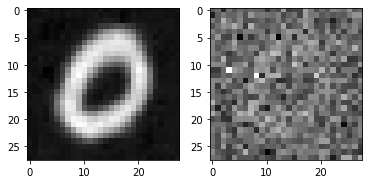

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5512.623
batch loss value:  5138.7812
batch loss value:  4791.191
batch loss value:  4904.609
batch loss value:  5791.648
batch loss value:  5445.462
batch loss value:  5063.7485
batch loss value:  5336.0293
batch loss value:  5090.7886
batch loss value:  5242.651
iteration: 6800 loss: 5996.925781
time step for image 18


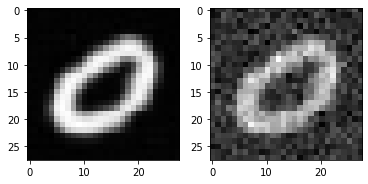

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5524.661
batch loss value:  6031.0557
batch loss value:  5158.9795
batch loss value:  5476.6284
batch loss value:  5325.0747
batch loss value:  5461.5415
batch loss value:  5183.907
batch loss value:  5350.6055
batch loss value:  4786.2773
batch loss value:  5175.3047
iteration: 6900 loss: 5714.115234
time step for image 164


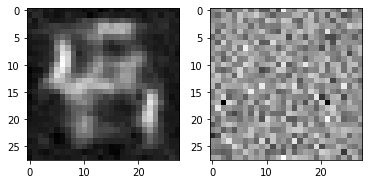

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5428.2036
batch loss value:  5059.8037
batch loss value:  5291.6016
batch loss value:  5092.5474
batch loss value:  5302.6553
batch loss value:  5068.3643
batch loss value:  5037.4355
batch loss value:  5163.676
batch loss value:  5416.461
batch loss value:  5776.9478
iteration: 7000 loss: 5697.160156
time step for image 59


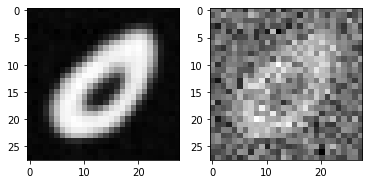

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5447.755
batch loss value:  5255.048
batch loss value:  5214.0005
batch loss value:  5718.86
batch loss value:  5122.0654
batch loss value:  5401.9624
batch loss value:  5556.039
batch loss value:  5457.815
batch loss value:  5130.333
batch loss value:  5103.8857
iteration: 7100 loss: 6050.626953
time step for image 193


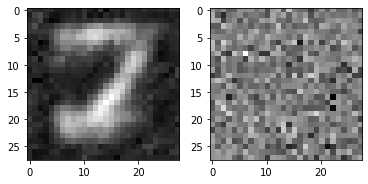

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4885.3135
batch loss value:  5291.9116
batch loss value:  5210.5615
batch loss value:  4864.074
batch loss value:  4788.0205
batch loss value:  5106.0225
batch loss value:  5142.3066
batch loss value:  5223.984
batch loss value:  5156.128
batch loss value:  5488.603
iteration: 7200 loss: 5638.427734
time step for image 57


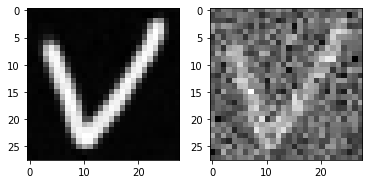

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5087.363
batch loss value:  5088.662
batch loss value:  5242.2783
batch loss value:  5076.243
batch loss value:  5211.763
batch loss value:  5041.2256
batch loss value:  5027.7354
batch loss value:  4607.1587
batch loss value:  5162.677
batch loss value:  5041.837
iteration: 7300 loss: 5594.073242
time step for image 166


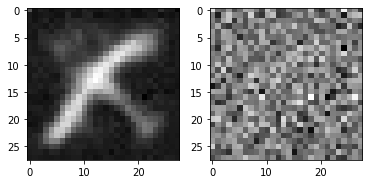

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5134.8687
batch loss value:  5535.1143
batch loss value:  5403.0234
batch loss value:  5359.1074
batch loss value:  5431.5337
batch loss value:  4677.214
batch loss value:  5699.292
batch loss value:  5375.75
batch loss value:  5217.458
batch loss value:  5262.6016
iteration: 7400 loss: 5798.375488
time step for image 142


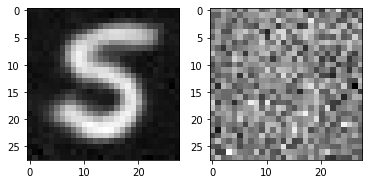

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5107.1562
batch loss value:  4871.498
batch loss value:  5201.865
batch loss value:  5154.9297
batch loss value:  5425.659
batch loss value:  5471.2295
batch loss value:  4970.145
batch loss value:  5179.504
batch loss value:  5596.735
batch loss value:  5209.7617
iteration: 7500 loss: 5628.530273
time step for image 116


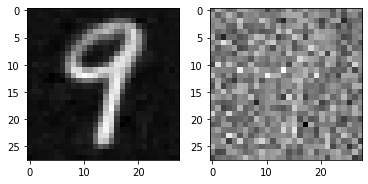

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4998.699
batch loss value:  5360.4297
batch loss value:  4817.272
batch loss value:  4812.951
batch loss value:  5549.3115
batch loss value:  5126.419
batch loss value:  5374.9756
batch loss value:  5443.488
batch loss value:  5483.917
batch loss value:  4989.3125
iteration: 7600 loss: 5814.750000
time step for image 245


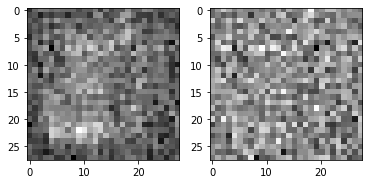

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5255.846
batch loss value:  5427.6743
batch loss value:  5374.082
batch loss value:  5232.967
batch loss value:  5008.202
batch loss value:  5327.092
batch loss value:  5344.009
batch loss value:  5158.8667
batch loss value:  5090.2314
batch loss value:  5534.1807
iteration: 7700 loss: 5614.185547
time step for image 186


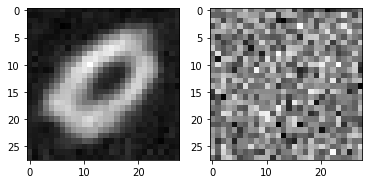

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5151.8354
batch loss value:  4849.3545
batch loss value:  5249.403
batch loss value:  4969.9883
batch loss value:  5546.9775
batch loss value:  4703.359
batch loss value:  5491.0977
batch loss value:  5141.6177
batch loss value:  5102.322
batch loss value:  4826.591
iteration: 7800 loss: 5560.287109
time step for image 185


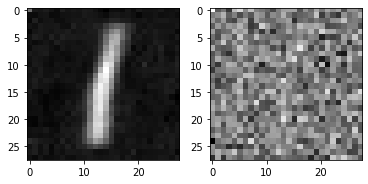

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5668.3843
batch loss value:  4755.9067
batch loss value:  5159.3643
batch loss value:  5489.481
batch loss value:  4943.5386
batch loss value:  4897.084
batch loss value:  5416.094
batch loss value:  5107.75
batch loss value:  5211.265
batch loss value:  5079.903
iteration: 7900 loss: 5561.333008
time step for image 118


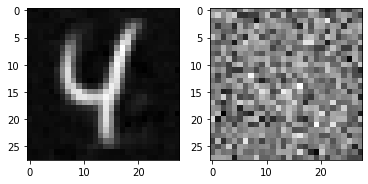

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5230.9395
batch loss value:  5034.338
batch loss value:  5241.9043
batch loss value:  4960.6533
batch loss value:  5264.1533
batch loss value:  5313.0605
batch loss value:  5116.8496
batch loss value:  5125.6353
batch loss value:  5308.808
batch loss value:  5100.7686
iteration: 8000 loss: 5483.813965
time step for image 55


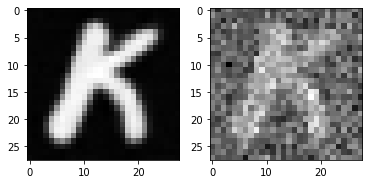

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5525.9287
batch loss value:  5469.9546
batch loss value:  4672.4434
batch loss value:  4937.713
batch loss value:  4654.4185
batch loss value:  5453.942
batch loss value:  4737.0703
batch loss value:  5173.7485
batch loss value:  5081.445
batch loss value:  4890.007
iteration: 8100 loss: 5705.571289
time step for image 135


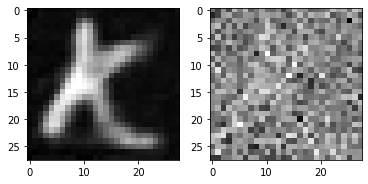

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5579.7227
batch loss value:  5181.7
batch loss value:  5060.001
batch loss value:  5430.9688
batch loss value:  5204.7812
batch loss value:  5251.1865
batch loss value:  4981.1963
batch loss value:  4880.744
batch loss value:  5269.757
batch loss value:  4911.31
iteration: 8200 loss: 5751.101074
time step for image 144


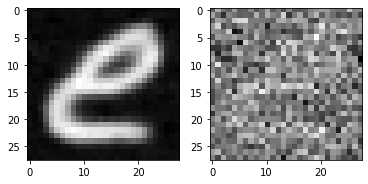

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4951.9326
batch loss value:  5065.077
batch loss value:  5054.682
batch loss value:  4913.91
batch loss value:  5404.7324
batch loss value:  5328.08
batch loss value:  5307.439
batch loss value:  4924.751
batch loss value:  5082.0327
batch loss value:  5252.786
iteration: 8300 loss: 5659.233887
time step for image 147


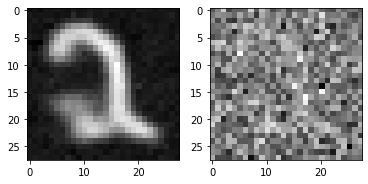

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5486.2144
batch loss value:  4992.7334
batch loss value:  5181.374
batch loss value:  4787.218
batch loss value:  5233.545
batch loss value:  4887.941
batch loss value:  5014.762
batch loss value:  4745.2314
batch loss value:  5022.0874
batch loss value:  5231.7314
iteration: 8400 loss: 5802.920898
time step for image 159


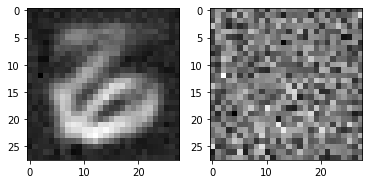

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5050.7773
batch loss value:  5096.9395
batch loss value:  4855.3857
batch loss value:  5415.88
batch loss value:  5257.592
batch loss value:  4991.461
batch loss value:  5499.544
batch loss value:  4594.675
batch loss value:  4992.064
batch loss value:  5122.1226
iteration: 8500 loss: 5786.751953
time step for image 91


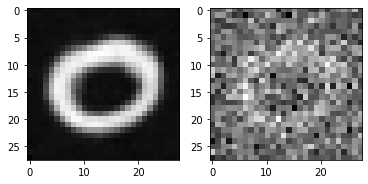

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4960.8965
batch loss value:  5514.576
batch loss value:  5315.993
batch loss value:  4801.775
batch loss value:  5096.659
batch loss value:  4973.8774
batch loss value:  5159.8564
batch loss value:  4993.6553
batch loss value:  5071.67
batch loss value:  5236.1313
iteration: 8600 loss: 5742.162598
time step for image 198


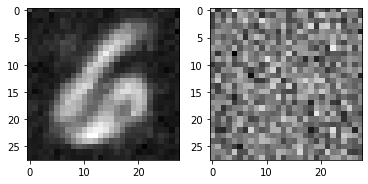

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5327.089
batch loss value:  4926.196
batch loss value:  5626.758
batch loss value:  5558.0205
batch loss value:  5114.6533
batch loss value:  5072.6855
batch loss value:  4928.504
batch loss value:  4654.304
saving iteration: 8680 loss: 5273.498047
batch loss value:  5107.9346
batch loss value:  4716.8154
iteration: 8700 loss: 5585.525391
time step for image 233


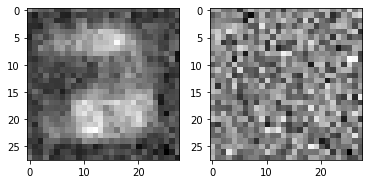

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4769.5464
batch loss value:  4813.674
batch loss value:  4913.58
batch loss value:  4770.133
batch loss value:  5282.707
batch loss value:  5145.6924
batch loss value:  4911.293
batch loss value:  5284.658
batch loss value:  5516.1855
batch loss value:  4546.4863
iteration: 8800 loss: 5612.712891
time step for image 89


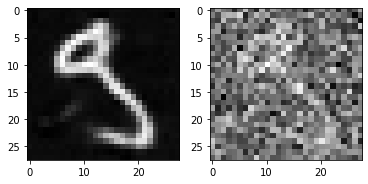

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4645.782
batch loss value:  4883.217
batch loss value:  4720.4263
batch loss value:  5146.4854
batch loss value:  5012.496
batch loss value:  4829.0645
batch loss value:  4958.301
batch loss value:  4992.4277
batch loss value:  5080.2866
batch loss value:  5209.758
iteration: 8900 loss: 5572.387695
time step for image 95


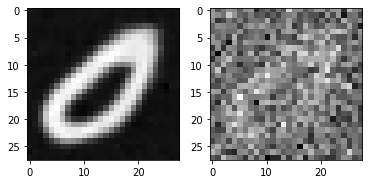

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4912.5874
batch loss value:  4583.755
batch loss value:  4808.575
batch loss value:  5163.242
batch loss value:  5152.8477
batch loss value:  4856.234
batch loss value:  5724.585
batch loss value:  5044.493
batch loss value:  5285.7407
batch loss value:  5102.378
iteration: 9000 loss: 5398.955078
time step for image 125


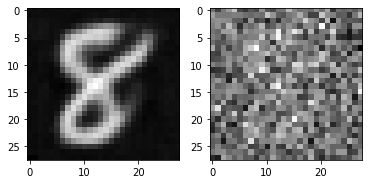

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5030.443
batch loss value:  5050.18
saving iteration: 9020 loss: 5269.450684
batch loss value:  4973.1875
batch loss value:  5301.7085
batch loss value:  5150.8228
batch loss value:  4935.7246
batch loss value:  4981.2324
batch loss value:  5173.7163
batch loss value:  5160.85
batch loss value:  4888.267
iteration: 9100 loss: 5483.978516
time step for image 100


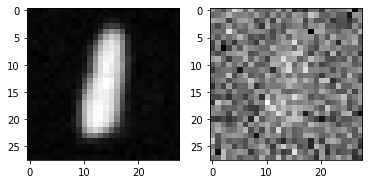

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5260.2627
batch loss value:  5010.1787
batch loss value:  5125.4316
batch loss value:  5439.0674
batch loss value:  5113.1133
batch loss value:  5313.3604
batch loss value:  5282.4062
batch loss value:  5151.448
batch loss value:  5455.025
batch loss value:  5159.2256
iteration: 9200 loss: 5474.380859
time step for image 41


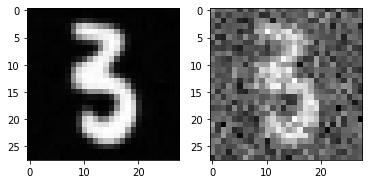

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5094.4463
batch loss value:  4806.906
batch loss value:  5108.1084
batch loss value:  5446.963
batch loss value:  4735.0205
batch loss value:  4976.8486
batch loss value:  4764.2227
batch loss value:  4739.1934
batch loss value:  4961.2754
batch loss value:  4868.8315
iteration: 9300 loss: 5436.828125
time step for image 34


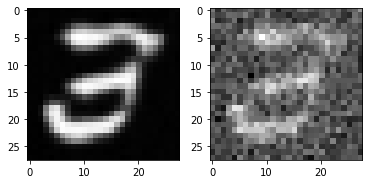

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5215.685
batch loss value:  5319.792
batch loss value:  4951.039
batch loss value:  5395.8145
batch loss value:  4881.282
batch loss value:  5000.337
batch loss value:  5079.9966
batch loss value:  4779.8135
batch loss value:  4814.28
batch loss value:  4752.918
iteration: 9400 loss: 5539.897461
time step for image 123


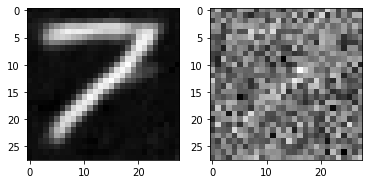

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4790.6387
batch loss value:  5556.7324
batch loss value:  5162.117
batch loss value:  5020.622
batch loss value:  5431.122
batch loss value:  4943.167
batch loss value:  5032.515
batch loss value:  4908.657
batch loss value:  5090.6904
batch loss value:  4890.505
iteration: 9500 loss: 5378.724609
time step for image 76


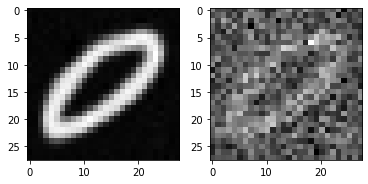

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5262.2017
batch loss value:  4571.7085
batch loss value:  5285.604
batch loss value:  4625.6216
batch loss value:  4722.0166
batch loss value:  5281.0464
batch loss value:  4883.21
batch loss value:  5023.5684
batch loss value:  4952.5107
batch loss value:  4881.49
iteration: 9600 loss: 5660.755371
time step for image 28


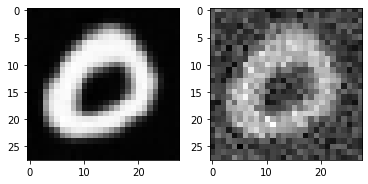

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4886.288
batch loss value:  4787.336
batch loss value:  5006.1064
batch loss value:  4886.8716
batch loss value:  5245.2754
batch loss value:  4823.005
batch loss value:  5008.765
batch loss value:  4970.854
batch loss value:  4977.2197
batch loss value:  5333.671
iteration: 9700 loss: 5557.844727
time step for image 204


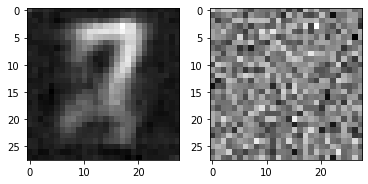

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4514.1143
batch loss value:  5083.5957
batch loss value:  5284.6475
batch loss value:  5341.4873
batch loss value:  4817.762
batch loss value:  4675.376
batch loss value:  4875.85
batch loss value:  5023.466
batch loss value:  5404.121
batch loss value:  5055.793
iteration: 9800 loss: 5480.117676
time step for image 193


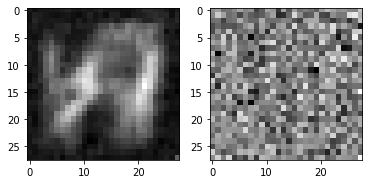

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4965.8496
batch loss value:  4800.0454
batch loss value:  4797.742
batch loss value:  4621.528
saving iteration: 9840 loss: 5194.072754
batch loss value:  5362.759
batch loss value:  5187.074
batch loss value:  5015.126
batch loss value:  5246.687
batch loss value:  4669.287
batch loss value:  4941.819
iteration: 9900 loss: 5320.136719
time step for image 181


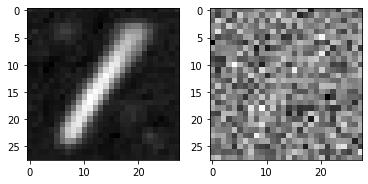

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5122.3057
batch loss value:  5225.7305
batch loss value:  4793.5107
batch loss value:  5570.159
batch loss value:  5094.142
batch loss value:  4822.879
batch loss value:  4536.238
batch loss value:  5058.416
batch loss value:  4843.502
batch loss value:  4964.356
iteration: 10000 loss: 5565.694824
time step for image 233


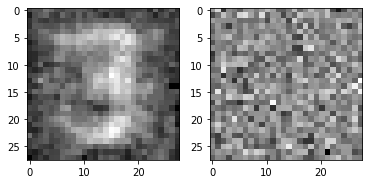

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5351.355
batch loss value:  5171.182
batch loss value:  4821.963
batch loss value:  4881.7065
batch loss value:  5150.6943
batch loss value:  5451.1777
batch loss value:  5145.001
batch loss value:  4661.283
saving iteration: 10080 loss: 5126.103516
batch loss value:  5603.348
batch loss value:  4854.813
iteration: 10100 loss: 5592.898438
time step for image 114


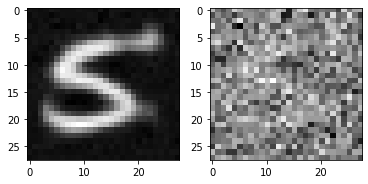

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4789.596
batch loss value:  4905.5405
batch loss value:  4756.3105
batch loss value:  5089.3037
batch loss value:  5430.5977
batch loss value:  4796.6475
batch loss value:  5095.82
batch loss value:  4736.205
batch loss value:  5003.9165
batch loss value:  5253.603
iteration: 10200 loss: 5294.049805
time step for image 7


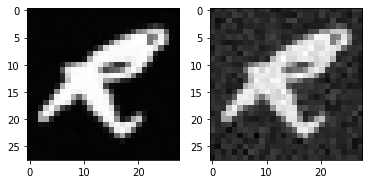

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5078.453
batch loss value:  5335.3657
batch loss value:  4984.8325
batch loss value:  5006.7754
batch loss value:  4776.4155
batch loss value:  4990.672
batch loss value:  5001.458
batch loss value:  4785.55
batch loss value:  5143.2334
batch loss value:  5058.615
iteration: 10300 loss: 5287.927734
time step for image 191


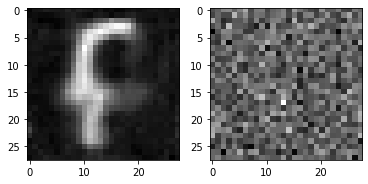

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4936.396
batch loss value:  4869.953
batch loss value:  4914.703
batch loss value:  4927.411
batch loss value:  5386.741
batch loss value:  5146.276
batch loss value:  4999.887
batch loss value:  5109.3296
batch loss value:  4844.801
batch loss value:  4948.8174
iteration: 10400 loss: 5508.382812
time step for image 119


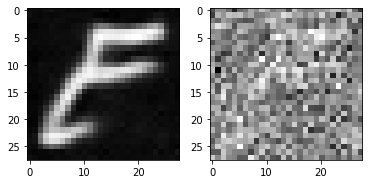

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5400.9556
batch loss value:  4817.414
batch loss value:  4696.1484
batch loss value:  4694.5625
batch loss value:  5272.0454
batch loss value:  5332.275
batch loss value:  4952.702
batch loss value:  5470.299
batch loss value:  4859.4106
batch loss value:  4735.99
iteration: 10500 loss: 5285.239258
time step for image 30


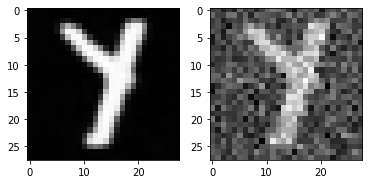

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4836.979
batch loss value:  5137.38
batch loss value:  4863.648
batch loss value:  5011.288
batch loss value:  4749.9526
batch loss value:  4945.2827
batch loss value:  5024.3896
batch loss value:  4895.297
batch loss value:  5221.9814
batch loss value:  4986.837
iteration: 10600 loss: 5332.450195
time step for image 194


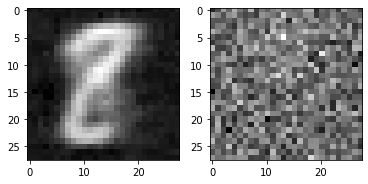

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4768.7227
batch loss value:  4817.575
batch loss value:  4782.7666
batch loss value:  4969.8936
batch loss value:  4843.884
batch loss value:  4689.305
batch loss value:  4823.212
batch loss value:  5009.545
batch loss value:  4774.7656
batch loss value:  4526.832
iteration: 10700 loss: 5300.954102
time step for image 79


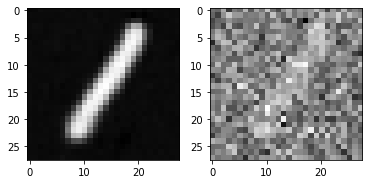

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5084.561
batch loss value:  5312.6133
batch loss value:  4626.6094
batch loss value:  4893.3867
batch loss value:  5608.079
batch loss value:  5011.3965
batch loss value:  4889.965
batch loss value:  5032.8916
batch loss value:  5156.524
batch loss value:  4723.7134
iteration: 10800 loss: 5243.652344
time step for image 156


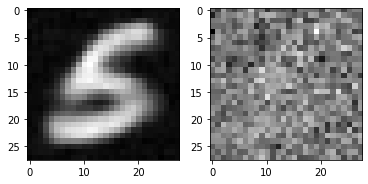

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5061.6763
batch loss value:  5074.0137
batch loss value:  4679.4507
batch loss value:  4572.216
batch loss value:  4517.749
batch loss value:  4434.0684
batch loss value:  5119.599
batch loss value:  4954.202
batch loss value:  4847.4043
batch loss value:  4761.6133
iteration: 10900 loss: 5290.894531
time step for image 231


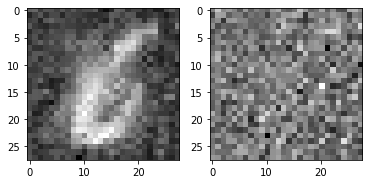

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4947.9688
batch loss value:  4935.466
batch loss value:  5398.2275
batch loss value:  4822.8706
batch loss value:  5124.5186
batch loss value:  4831.874
batch loss value:  5085.732
batch loss value:  4967.826
batch loss value:  4906.337
batch loss value:  4945.985
iteration: 11000 loss: 5413.934082
time step for image 221


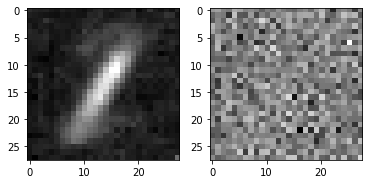

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4765.076
batch loss value:  4888.107
batch loss value:  5146.3477
batch loss value:  5130.692
batch loss value:  4906.5
batch loss value:  4805.043
batch loss value:  4253.879
batch loss value:  4925.23
batch loss value:  4703.3066
batch loss value:  5039.3516
iteration: 11100 loss: 5243.263672
time step for image 238


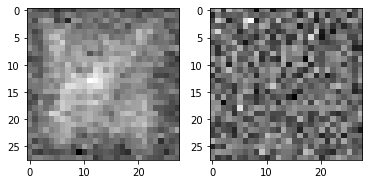

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4266.5454
batch loss value:  5255.407
batch loss value:  4720.4736
batch loss value:  5150.9854
batch loss value:  5030.921
batch loss value:  4810.7695
batch loss value:  5185.6816
batch loss value:  4884.6826
batch loss value:  4661.953
batch loss value:  5509.3643
iteration: 11200 loss: 5567.489258
time step for image 155


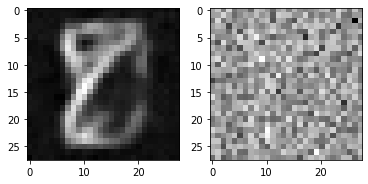

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5003.4004
batch loss value:  4985.7954
batch loss value:  5271.332
batch loss value:  4837.7764
batch loss value:  4996.6924
batch loss value:  4980.9434
batch loss value:  4759.515
batch loss value:  5043.4883
batch loss value:  4955.9917
batch loss value:  5345.293
iteration: 11300 loss: 5358.351562
time step for image 212


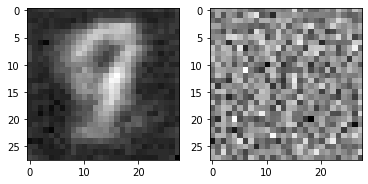

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4947.3394
batch loss value:  4889.034
batch loss value:  4753.2896
batch loss value:  5031.58
batch loss value:  5286.5474
batch loss value:  4990.5903
batch loss value:  4996.9907
batch loss value:  4990.545
batch loss value:  4626.2188
batch loss value:  5052.2676
iteration: 11400 loss: 5376.905273
time step for image 218


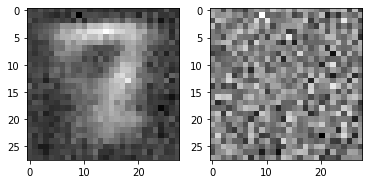

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4580.6807
batch loss value:  4759.947
batch loss value:  4645.0146
batch loss value:  5235.9307
batch loss value:  4796.9775
batch loss value:  4387.438
batch loss value:  4733.088
batch loss value:  4872.2827
batch loss value:  4720.4526
batch loss value:  4993.1807
iteration: 11500 loss: 5415.620117
time step for image 180


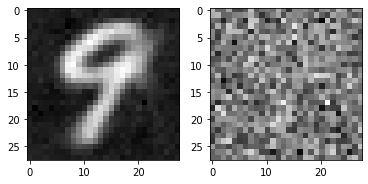

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4713.502
batch loss value:  4844.273
batch loss value:  4815.0186
batch loss value:  4990.586
batch loss value:  5070.1753
batch loss value:  4682.1978
batch loss value:  5102.1846
batch loss value:  4832.2354
saving iteration: 11580 loss: 5062.333008
batch loss value:  4853.456
batch loss value:  4875.506
iteration: 11600 loss: 5287.314941
time step for image 117


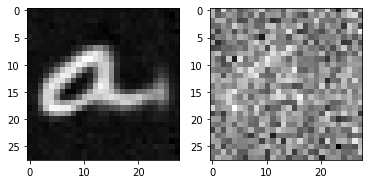

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4859.0938
batch loss value:  5079.8877
batch loss value:  4687.658
batch loss value:  4583.875
batch loss value:  4990.4375
batch loss value:  4979.9634
batch loss value:  4793.798
batch loss value:  5097.01
batch loss value:  5284.5493
batch loss value:  5344.415
iteration: 11700 loss: 5104.099609
time step for image 142


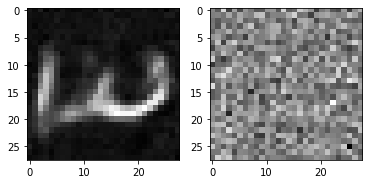

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5210.835
batch loss value:  4987.87
batch loss value:  5149.5186
batch loss value:  4823.86
batch loss value:  5206.048
batch loss value:  4732.2734
batch loss value:  4510.989
batch loss value:  4949.7954
batch loss value:  4600.2383
batch loss value:  4796.828
iteration: 11800 loss: 5300.334961
time step for image 145


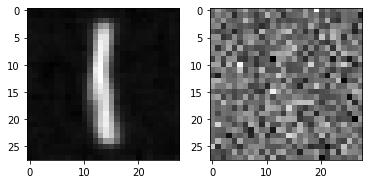

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5137.623
batch loss value:  4956.1895
batch loss value:  5035.023
batch loss value:  5260.7617
batch loss value:  4591.2314
batch loss value:  4699.1797
batch loss value:  4877.9297
batch loss value:  4846.723
batch loss value:  5035.3276
batch loss value:  4753.421
iteration: 11900 loss: 5419.327148
time step for image 233


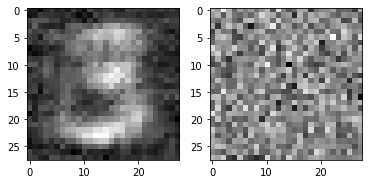

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4860.2266
batch loss value:  5183.3135
batch loss value:  4577.356
batch loss value:  5074.3037
batch loss value:  4792.383
batch loss value:  4560.75
batch loss value:  4830.379
batch loss value:  4800.1865
batch loss value:  4624.7295
batch loss value:  5135.7676
iteration: 12000 loss: 5408.823242
time step for image 46


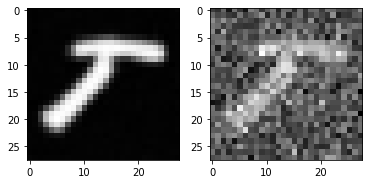

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4910.992
batch loss value:  5052.883
batch loss value:  4791.32
batch loss value:  4551.328
batch loss value:  5077.544
batch loss value:  4515.9014
batch loss value:  4870.588
batch loss value:  4758.5396
batch loss value:  4806.3145
batch loss value:  4682.075
iteration: 12100 loss: 5225.413574
time step for image 148


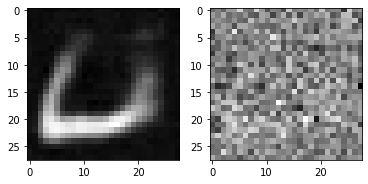

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4966.88
batch loss value:  4655.1606
batch loss value:  5154.332
batch loss value:  4825.8706
batch loss value:  4503.5156
batch loss value:  4909.61
batch loss value:  4941.096
batch loss value:  4976.702
batch loss value:  4958.6284
batch loss value:  4524.9106
iteration: 12200 loss: 5277.891602
time step for image 11


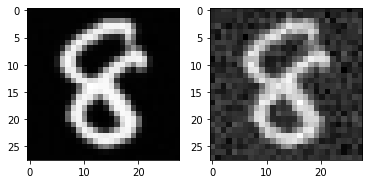

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4522.783
batch loss value:  4893.288
batch loss value:  4914.3564
batch loss value:  5333.0454
batch loss value:  4361.4814
batch loss value:  4872.092
batch loss value:  5076.2363
batch loss value:  5098.799
batch loss value:  4828.934
batch loss value:  4942.115
iteration: 12300 loss: 5467.980469
time step for image 145


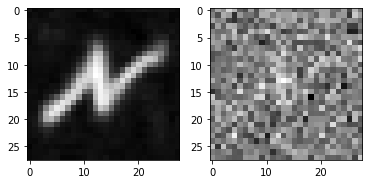

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5139.085
batch loss value:  5047.59
batch loss value:  5043.124
batch loss value:  4993.542
batch loss value:  4731.5684
batch loss value:  5090.5103
batch loss value:  4807.62
batch loss value:  4910.5225
batch loss value:  4938.6006
batch loss value:  4752.8887
iteration: 12400 loss: 5387.319336
time step for image 94


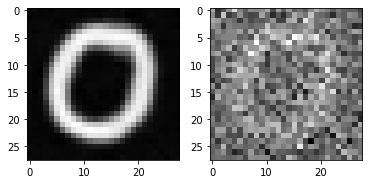

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5031.6133
batch loss value:  5175.3696
batch loss value:  4560.46
batch loss value:  5280.313
batch loss value:  4718.5693
batch loss value:  4542.8022
batch loss value:  4961.9497
batch loss value:  5182.9526
batch loss value:  4768.252
batch loss value:  4812.788
iteration: 12500 loss: 5479.544922
time step for image 177


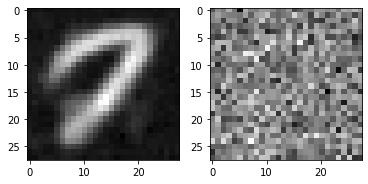

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4885.5215
batch loss value:  4915.4014
batch loss value:  4740.036
batch loss value:  4929.1377
batch loss value:  5194.68
batch loss value:  5044.784
batch loss value:  4923.1846
batch loss value:  5007.045
batch loss value:  4673.6504
batch loss value:  4512.1885
iteration: 12600 loss: 5170.773438
time step for image 64


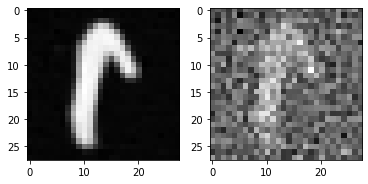

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5085.9736
batch loss value:  4465.497
batch loss value:  4573.2754
batch loss value:  4817.502
batch loss value:  4677.4756
batch loss value:  4918.2812
batch loss value:  4554.3066
batch loss value:  5351.139
batch loss value:  4532.3477
batch loss value:  4470.6094
iteration: 12700 loss: 5156.304199
time step for image 244


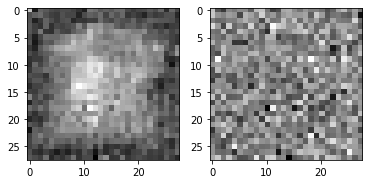

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4820.462
batch loss value:  4726.4985
batch loss value:  4949.908
batch loss value:  4658.873
batch loss value:  4721.632
batch loss value:  4757.467
batch loss value:  4840.4863
batch loss value:  5000.205
batch loss value:  4735.8525
batch loss value:  4666.874
iteration: 12800 loss: 5115.543945
time step for image 248


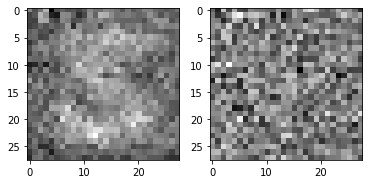

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4583.5117
batch loss value:  4755.2646
batch loss value:  4983.5195
batch loss value:  4749.416
batch loss value:  4566.946
batch loss value:  4908.115
batch loss value:  4640.621
batch loss value:  4900.187
batch loss value:  4418.207
batch loss value:  5137.4478
iteration: 12900 loss: 5150.955566
time step for image 125


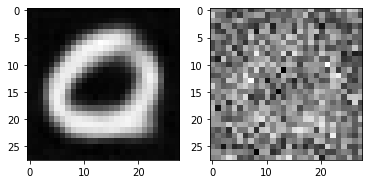

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4742.5586
batch loss value:  4848.128
batch loss value:  4860.2812
batch loss value:  4589.6523
batch loss value:  5608.189
batch loss value:  4892.6104
batch loss value:  4477.9346
batch loss value:  4650.415
saving iteration: 12980 loss: 5033.243652
batch loss value:  4826.45
batch loss value:  4665.17
iteration: 13000 loss: 5420.971680
time step for image 204


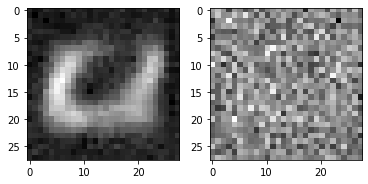

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4944.6904
batch loss value:  5187.716
batch loss value:  4745.9307
batch loss value:  4697.3613
batch loss value:  4988.4106
batch loss value:  4792.7715
batch loss value:  4481.0273
batch loss value:  4827.1484
batch loss value:  4922.783
batch loss value:  4693.4873
iteration: 13100 loss: 5112.663574
time step for image 155


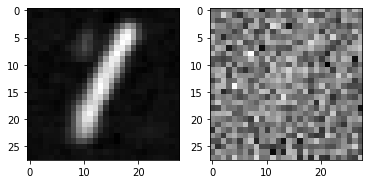

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4660.9814
batch loss value:  4651.7686
batch loss value:  5211.7363
batch loss value:  4585.2925
batch loss value:  4850.8765
batch loss value:  4815.1514
batch loss value:  4888.653
batch loss value:  5136.2324
batch loss value:  4598.5186
batch loss value:  4674.075
iteration: 13200 loss: 5201.667969
time step for image 12


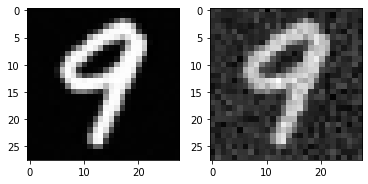

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4651.233
batch loss value:  5034.8506
batch loss value:  4955.8438
batch loss value:  4711.85
batch loss value:  4624.519
batch loss value:  4975.126
batch loss value:  4802.418
batch loss value:  4410.677
batch loss value:  4535.8877
batch loss value:  5080.4805
iteration: 13300 loss: 5250.280273
time step for image 162


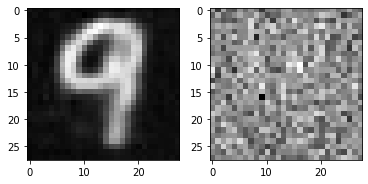

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4753.208
batch loss value:  4822.4756
batch loss value:  4836.303
batch loss value:  4992.002
batch loss value:  5206.2886
batch loss value:  5304.2363
batch loss value:  4561.456
batch loss value:  5024.3525
batch loss value:  4826.9395
batch loss value:  4489.0444
iteration: 13400 loss: 5268.841797
time step for image 174


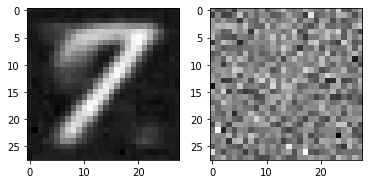

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5000.16
batch loss value:  4779.5156
batch loss value:  4655.657
batch loss value:  4711.362
batch loss value:  4526.037
batch loss value:  4575.716
batch loss value:  5089.7285
batch loss value:  4679.3066
saving iteration: 13480 loss: 5005.513184
batch loss value:  4662.6123
batch loss value:  4859.289
iteration: 13500 loss: 5447.187500
time step for image 121


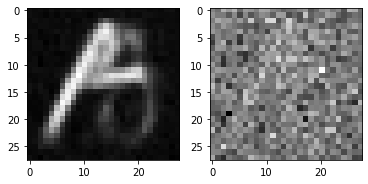

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4949.968
batch loss value:  4964.934
batch loss value:  5057.1025
batch loss value:  4972.4297
batch loss value:  4675.4263
batch loss value:  4567.468
batch loss value:  4884.9365
batch loss value:  5206.075
batch loss value:  4725.2285
batch loss value:  4803.5254
iteration: 13600 loss: 5313.936523
time step for image 78


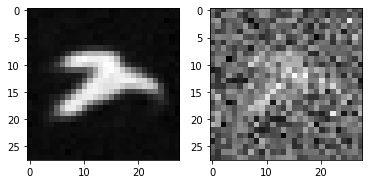

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4866.1006
batch loss value:  4880.735
batch loss value:  4875.126
batch loss value:  4620.681
batch loss value:  4827.963
batch loss value:  4540.8027
batch loss value:  4465.321
batch loss value:  4714.3735
batch loss value:  5149.8506
batch loss value:  4690.278
iteration: 13700 loss: 5266.653320
time step for image 57


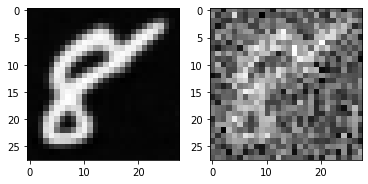

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5023.163
batch loss value:  4613.2427
batch loss value:  4225.2573
batch loss value:  4664.1304
batch loss value:  4665.391
batch loss value:  4617.2905
batch loss value:  5008.134
batch loss value:  4706.999
batch loss value:  4658.807
batch loss value:  4769.717
iteration: 13800 loss: 5222.149902
time step for image 160


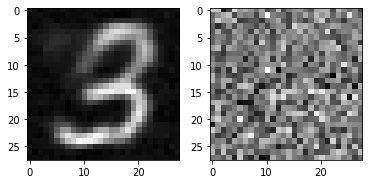

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4679.8145
batch loss value:  5194.155
batch loss value:  5383.218
batch loss value:  4967.1006
batch loss value:  4869.9487
batch loss value:  4745.385
batch loss value:  4712.3716
batch loss value:  4941.8145
batch loss value:  4705.845
batch loss value:  4915.8975
iteration: 13900 loss: 5115.446289
time step for image 167


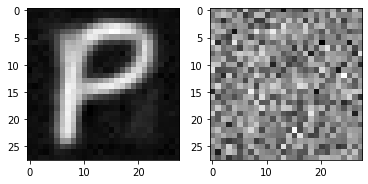

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4631.84
batch loss value:  4945.2544
batch loss value:  4857.8745
batch loss value:  4761.3203
saving iteration: 13940 loss: 4990.600586
batch loss value:  4754.8003
batch loss value:  5195.54
batch loss value:  4470.731
batch loss value:  4386.9478
batch loss value:  4727.6587
batch loss value:  4772.2153
iteration: 14000 loss: 5352.074219
time step for image 47


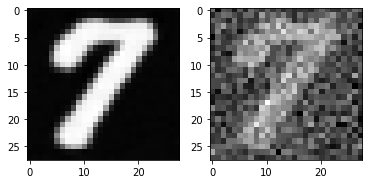

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4798.8486
batch loss value:  4947.1084
batch loss value:  4935.982
batch loss value:  4918.9775
batch loss value:  4970.532
batch loss value:  4742.2393
batch loss value:  4895.459
batch loss value:  4515.574
batch loss value:  4904.187
batch loss value:  4476.086
iteration: 14100 loss: 5351.640625
time step for image 20


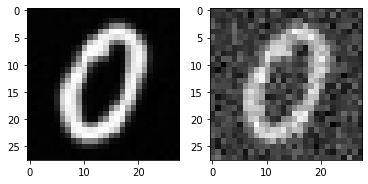

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4990.96
batch loss value:  5027.135
batch loss value:  4635.708
batch loss value:  4630.3887
batch loss value:  4727.584
batch loss value:  4501.723
batch loss value:  4670.99
batch loss value:  4885.1475
batch loss value:  5287.8564
batch loss value:  4663.846
iteration: 14200 loss: 5311.400391
time step for image 7


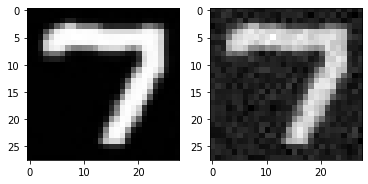

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4778.3896
batch loss value:  4342.82
batch loss value:  4899.0527
batch loss value:  4513.308
batch loss value:  4592.221
batch loss value:  4982.162
batch loss value:  4929.362
batch loss value:  4971.5547
batch loss value:  4600.4404
batch loss value:  5207.1704
iteration: 14300 loss: 5325.195312
time step for image 86


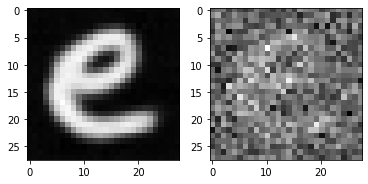

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5509.3394
batch loss value:  4605.0234
batch loss value:  5159.595
batch loss value:  4768.369
batch loss value:  4830.4966
batch loss value:  4436.816
saving iteration: 14360 loss: 4851.460938
batch loss value:  4916.0015
batch loss value:  4719.339
batch loss value:  5111.9443
batch loss value:  4953.536
iteration: 14400 loss: 5321.033691
time step for image 0


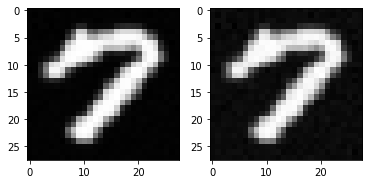

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4505.7603
batch loss value:  4821.2554
batch loss value:  4925.8184
batch loss value:  4417.6523
batch loss value:  4607.6978
batch loss value:  4607.2617
batch loss value:  4811.1885
batch loss value:  4353.2773
batch loss value:  4620.28
batch loss value:  4707.418
iteration: 14500 loss: 5216.771973
time step for image 96


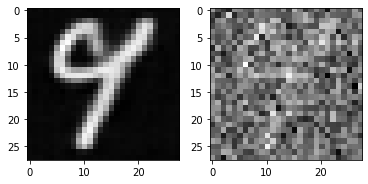

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4732.7754
batch loss value:  4912.3525
batch loss value:  4562.082
batch loss value:  4685.431
batch loss value:  4871.8477
batch loss value:  4999.8623
batch loss value:  4464.6455
batch loss value:  4602.3223
batch loss value:  4909.0806
batch loss value:  4701.4395
iteration: 14600 loss: 5261.940430
time step for image 44


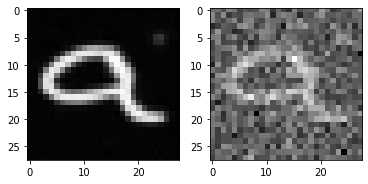

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4279.919
batch loss value:  4766.092
batch loss value:  4811.077
batch loss value:  4738.443
batch loss value:  5280.707
batch loss value:  4626.156
batch loss value:  4759.589
batch loss value:  4638.653
batch loss value:  4632.952
batch loss value:  4707.8867
iteration: 14700 loss: 5437.431152
time step for image 143


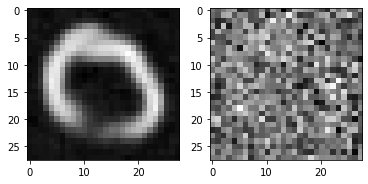

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4371.573
batch loss value:  4908.5244
batch loss value:  4412.5435
batch loss value:  4493.99
batch loss value:  4907.5913
batch loss value:  4871.184
batch loss value:  4873.5396
batch loss value:  4676.2603
batch loss value:  4367.1274
batch loss value:  4631.079
iteration: 14800 loss: 5236.465820
time step for image 179


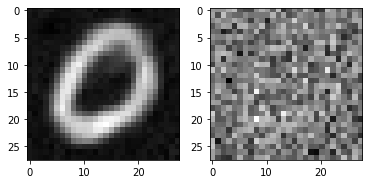

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4558.448
batch loss value:  5549.2285
batch loss value:  5095.5244
batch loss value:  4525.9307
batch loss value:  4230.338
batch loss value:  4825.6436
batch loss value:  4771.7793
batch loss value:  4881.4863
batch loss value:  4526.089
batch loss value:  4614.505
iteration: 14900 loss: 5241.207031
time step for image 130


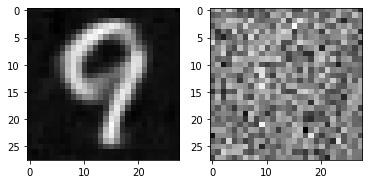

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5083.769
batch loss value:  4992.284
batch loss value:  4494.7544
batch loss value:  4809.0605
batch loss value:  5067.6006
batch loss value:  4498.9824
batch loss value:  4548.2026
batch loss value:  4673.7583
batch loss value:  4848.7495
batch loss value:  4733.083
iteration: 15000 loss: 5130.242188
time step for image 159


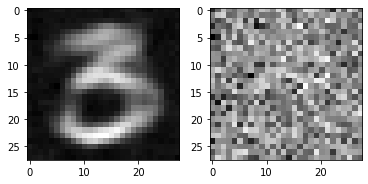

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4587.506
batch loss value:  4796.197
batch loss value:  4471.0015
batch loss value:  4744.559
batch loss value:  4786.5176
batch loss value:  4607.123
batch loss value:  4989.3657
batch loss value:  4797.9834
batch loss value:  4769.8384
batch loss value:  4852.818
iteration: 15100 loss: 5312.259277
time step for image 231


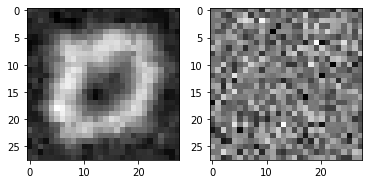

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4594.2017
batch loss value:  4588.1553
batch loss value:  4350.5215
batch loss value:  4580.6455
batch loss value:  4555.5938
batch loss value:  4452.7983
batch loss value:  4681.832
batch loss value:  4547.1045
batch loss value:  4542.407
batch loss value:  4456.6025
iteration: 15200 loss: 5186.956055
time step for image 160


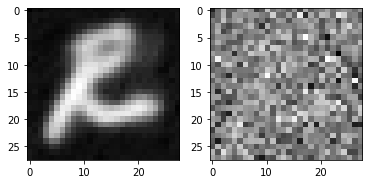

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4875.8027
batch loss value:  4944.418
batch loss value:  4628.6855
batch loss value:  4681.667
batch loss value:  4788.594
batch loss value:  4707.918
batch loss value:  4764.898
batch loss value:  4853.6494
batch loss value:  4570.8813
batch loss value:  4353.9844
iteration: 15300 loss: 5085.858398
time step for image 102


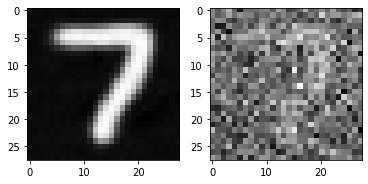

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4806.261
batch loss value:  4718.9478
batch loss value:  5537.166
batch loss value:  5072.8374
batch loss value:  4593.589
batch loss value:  4992.72
batch loss value:  4402.1113
batch loss value:  4602.289
batch loss value:  4762.3384
batch loss value:  4561.919
iteration: 15400 loss: 5125.850586
time step for image 107


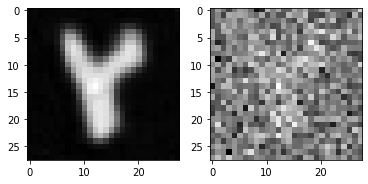

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5148.292
batch loss value:  4737.3145
batch loss value:  4773.9316
batch loss value:  5054.3955
batch loss value:  4825.9746
batch loss value:  4934.865
batch loss value:  4821.3516
batch loss value:  4680.922
batch loss value:  4603.9653
batch loss value:  4452.1245
iteration: 15500 loss: 5184.504395
time step for image 219


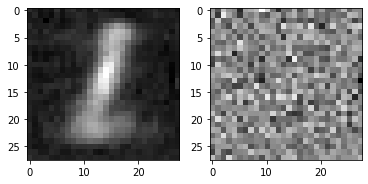

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4391.377
batch loss value:  4514.1953
batch loss value:  4679.035
batch loss value:  4596.763
batch loss value:  4784.7334
batch loss value:  4713.285
batch loss value:  4487.873
batch loss value:  4990.433
batch loss value:  4745.5234
batch loss value:  4711.065
iteration: 15600 loss: 5007.345215
time step for image 74


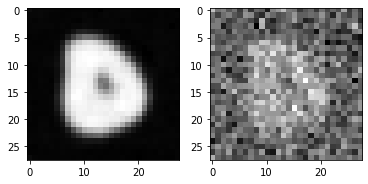

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4976.175
batch loss value:  4384.2803
saving iteration: 15620 loss: 4784.609375
batch loss value:  4704.036
batch loss value:  4776.4883
batch loss value:  4800.7305
batch loss value:  4476.789
batch loss value:  4589.8906
batch loss value:  4721.556
batch loss value:  5059.1245
batch loss value:  4856.129
iteration: 15700 loss: 5353.818359
time step for image 148


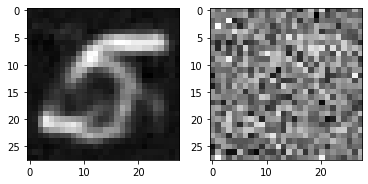

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4624.3584
batch loss value:  4777.1934
batch loss value:  4574.2314
batch loss value:  4986.4785
batch loss value:  4433.7383
batch loss value:  4925.171
batch loss value:  4642.568
batch loss value:  4762.386
batch loss value:  4832.706
batch loss value:  4621.343
iteration: 15800 loss: 5329.804688
time step for image 231


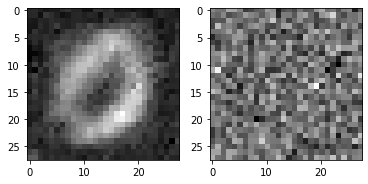

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4688.424
batch loss value:  4721.8926
batch loss value:  4568.127
batch loss value:  5138.6377
batch loss value:  4719.796
batch loss value:  4795.8877
batch loss value:  4336.416
batch loss value:  4438.2935
batch loss value:  4446.209
batch loss value:  4599.1816
iteration: 15900 loss: 5150.966797
time step for image 162


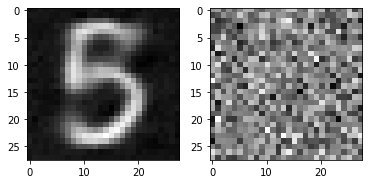

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4673.585
batch loss value:  4531.047
batch loss value:  4830.267
batch loss value:  4665.956
batch loss value:  5069.6997
batch loss value:  4281.014
batch loss value:  4263.6724
batch loss value:  4620.951
batch loss value:  4819.493
batch loss value:  4405.629
iteration: 16000 loss: 5095.203125
time step for image 143


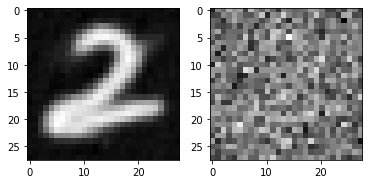

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4887.0176
batch loss value:  4683.4375
batch loss value:  4607.665
batch loss value:  5117.8633
batch loss value:  5022.1104
batch loss value:  4521.2393
batch loss value:  4617.6157
batch loss value:  4627.697
batch loss value:  4457.543
batch loss value:  4515.8867
iteration: 16100 loss: 4994.172852
time step for image 6


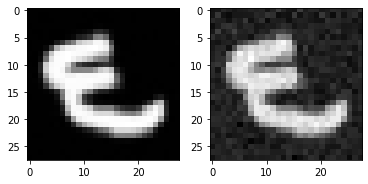

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4793.238
batch loss value:  4382.9995
batch loss value:  4660.677
batch loss value:  4735.6416
batch loss value:  4882.5283
batch loss value:  4505.869
batch loss value:  4942.9854
batch loss value:  4796.328
batch loss value:  4840.836
batch loss value:  4628.636
iteration: 16200 loss: 5075.279297
time step for image 48


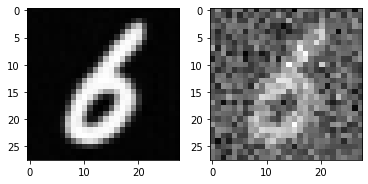

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5001.6147
batch loss value:  5140.2056
batch loss value:  4749.6143
batch loss value:  4950.002
batch loss value:  4532.7417
batch loss value:  4340.5747
batch loss value:  5015.1074
batch loss value:  4549.741
batch loss value:  4531.218
batch loss value:  4914.838
iteration: 16300 loss: 5279.826660
time step for image 58


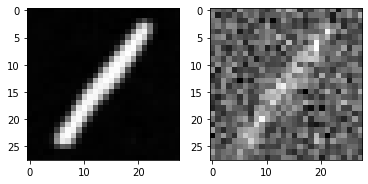

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4263.047
batch loss value:  4714.7563
batch loss value:  5053.509
batch loss value:  4586.0596
batch loss value:  4572.338
batch loss value:  4614.95
batch loss value:  4862.422
batch loss value:  4792.5938
batch loss value:  4590.049
batch loss value:  5011.7383
iteration: 16400 loss: 5046.988281
time step for image 131


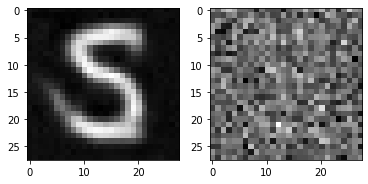

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4551.4624
batch loss value:  4497.2764
batch loss value:  5114.9067
batch loss value:  4546.212
batch loss value:  4299.146
batch loss value:  4564.151
batch loss value:  5079.674
batch loss value:  4772.686
batch loss value:  4228.898
batch loss value:  4607.293
iteration: 16500 loss: 5038.635742
time step for image 190


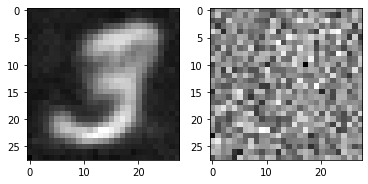

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4134.424
batch loss value:  4860.3945
batch loss value:  4488.051
batch loss value:  4626.179
batch loss value:  4594.4287
batch loss value:  4907.1484
batch loss value:  4648.1973
batch loss value:  4972.789
batch loss value:  4792.6514
batch loss value:  5005.1577
iteration: 16600 loss: 5252.892578
time step for image 124


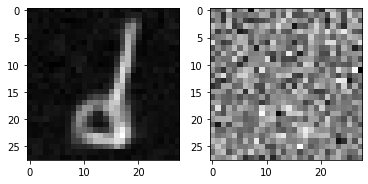

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4883.3564
batch loss value:  4696.7334
batch loss value:  4647.9263
batch loss value:  4868.146
batch loss value:  5164.9375
batch loss value:  4823.3643
batch loss value:  4897.786
batch loss value:  4738.0425
batch loss value:  4598.279
batch loss value:  5129.571
iteration: 16700 loss: 4991.118164
time step for image 163


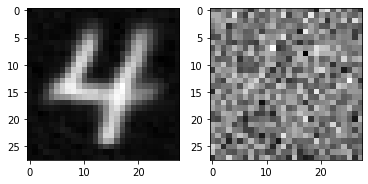

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4349.441
batch loss value:  4666.3154
batch loss value:  4913.3525
batch loss value:  4679.5215
batch loss value:  5013.872
batch loss value:  4367.753
batch loss value:  4821.19
batch loss value:  4636.9077
batch loss value:  5277.3213
batch loss value:  4518.129
iteration: 16800 loss: 4936.982910
time step for image 115


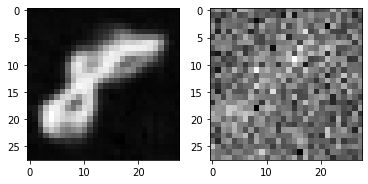

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4870.916
batch loss value:  4617.7334
batch loss value:  4456.217
batch loss value:  4407.897
batch loss value:  4864.848
batch loss value:  4624.8867
batch loss value:  4764.092
batch loss value:  4471.9736
batch loss value:  4903.2188
batch loss value:  4959.7573
iteration: 16900 loss: 5061.145508
time step for image 177


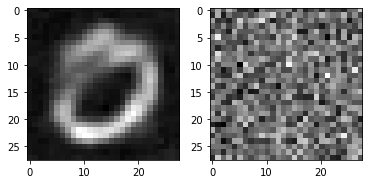

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4553.5737
batch loss value:  5036.2607
batch loss value:  5096.5596
batch loss value:  4506.7603
batch loss value:  4634.311
batch loss value:  4777.2236
batch loss value:  4725.8896
batch loss value:  4671.246
batch loss value:  4616.579
batch loss value:  4427.668
iteration: 17000 loss: 5126.232910
time step for image 172


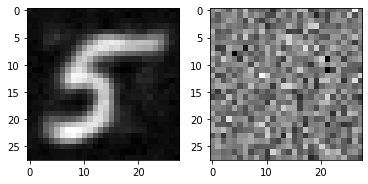

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4404.6465
batch loss value:  4849.6875
batch loss value:  4497.804
batch loss value:  4286.299
batch loss value:  4709.157
batch loss value:  4640.473
batch loss value:  4936.883
batch loss value:  5036.4595
batch loss value:  5246.3525
batch loss value:  4707.927
iteration: 17100 loss: 5196.208496
time step for image 157


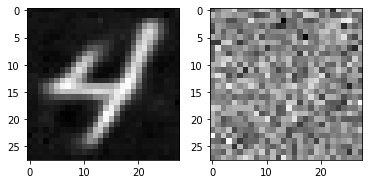

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4557.609
batch loss value:  4652.531
batch loss value:  4750.006
batch loss value:  4656.45
batch loss value:  4441.6235
batch loss value:  4679.519
batch loss value:  4693.8125
batch loss value:  4754.6323
batch loss value:  4556.5615
batch loss value:  4844.1147
iteration: 17200 loss: 5154.603027
time step for image 143


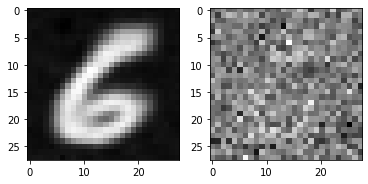

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4403.6885
batch loss value:  4600.0205
batch loss value:  4714.1797
batch loss value:  4419.2417
batch loss value:  4935.7393
batch loss value:  4925.284
batch loss value:  4700.809
batch loss value:  4949.373
batch loss value:  4495.124
batch loss value:  4624.5205
iteration: 17300 loss: 5041.297852
time step for image 109


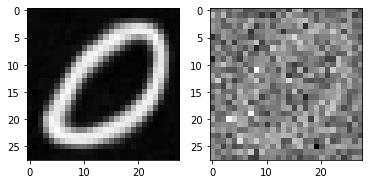

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4569.293
batch loss value:  4395.502
batch loss value:  4383.1167
batch loss value:  4478.8135
batch loss value:  4926.5967
batch loss value:  4592.7754
batch loss value:  4701.8213
batch loss value:  4524.8516
batch loss value:  4958.521
batch loss value:  5001.6426
iteration: 17400 loss: 5135.049805
time step for image 17


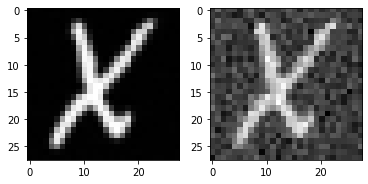

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4503.6533
batch loss value:  4502.452
batch loss value:  4488.166
batch loss value:  5009.0303
batch loss value:  4357.7764
batch loss value:  4360.9746
batch loss value:  4792.007
batch loss value:  5061.341
batch loss value:  4415.6206
batch loss value:  4761.326
iteration: 17500 loss: 5195.876465
time step for image 211


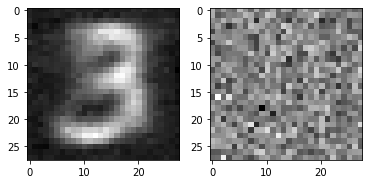

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4568.4478
batch loss value:  4600.506
batch loss value:  4453.0825
batch loss value:  4507.2793
batch loss value:  4674.762
batch loss value:  4980.53
batch loss value:  4615.9663
batch loss value:  4532.326
batch loss value:  4672.208
batch loss value:  4860.0796
iteration: 17600 loss: 5075.892578
time step for image 235


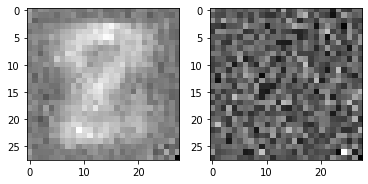

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4887.7256
batch loss value:  4259.076
batch loss value:  4679.117
batch loss value:  4333.6387
batch loss value:  4821.255
batch loss value:  4964.342
batch loss value:  4349.1953
batch loss value:  5021.8613
batch loss value:  4948.1655
batch loss value:  4863.209
iteration: 17700 loss: 5200.679688
time step for image 32


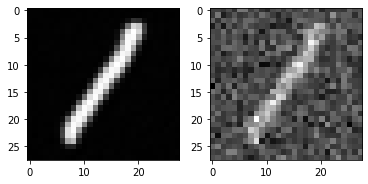

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4875.162
batch loss value:  4306.495
batch loss value:  4798.0435
batch loss value:  4906.101
batch loss value:  4390.0854
batch loss value:  4376.7197
batch loss value:  4408.4043
batch loss value:  4382.8555
batch loss value:  4394.229
batch loss value:  4590.8247
iteration: 17800 loss: 5236.563965
time step for image 214


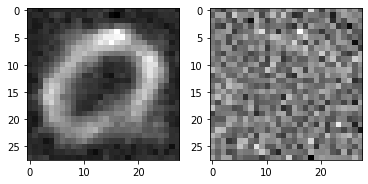

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4787.1143
batch loss value:  4831.0635
batch loss value:  4655.233
batch loss value:  4535.714
batch loss value:  4530.274
batch loss value:  4563.2256
batch loss value:  5049.005
batch loss value:  4560.247
batch loss value:  4528.1074
batch loss value:  5133.5703
iteration: 17900 loss: 4973.253906
time step for image 207


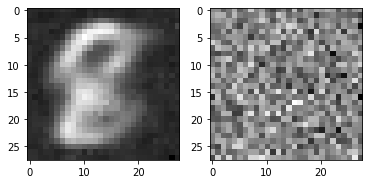

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4645.2
batch loss value:  5008.8945
batch loss value:  4841.715
batch loss value:  4678.241
batch loss value:  4879.768
batch loss value:  4791.255
batch loss value:  4720.8926
batch loss value:  4490.17
batch loss value:  4752.217
batch loss value:  4617.1523
iteration: 18000 loss: 5105.190430
time step for image 8


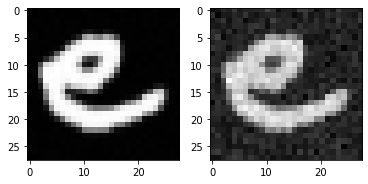

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4872.961
batch loss value:  4438.103
batch loss value:  4572.841
batch loss value:  4690.3486
batch loss value:  4644.085
batch loss value:  4599.5957
batch loss value:  4675.6396
batch loss value:  4642.079
batch loss value:  4527.198
batch loss value:  4659.1675
iteration: 18100 loss: 4964.306641
time step for image 156


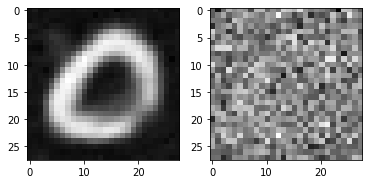

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4282.9297
batch loss value:  4526.671
batch loss value:  4635.6045
batch loss value:  4640.757
batch loss value:  4880.5664
batch loss value:  4768.1904
batch loss value:  4784.708
batch loss value:  4599.712
batch loss value:  4776.6875
batch loss value:  4599.3945
iteration: 18200 loss: 5098.631836
time step for image 12


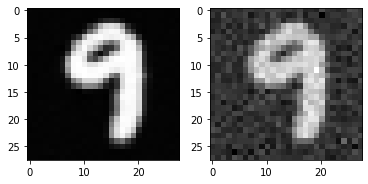

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4479.3623
batch loss value:  4915.024
batch loss value:  4621.567
batch loss value:  4712.2354
batch loss value:  4736.501
batch loss value:  4376.273
batch loss value:  4689.408
batch loss value:  4799.3896
batch loss value:  4705.123
batch loss value:  4959.522
iteration: 18300 loss: 5153.190430
time step for image 22


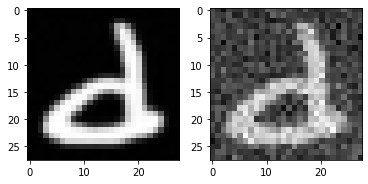

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4453.2627
batch loss value:  4784.169
batch loss value:  4691.631
batch loss value:  4711.327
batch loss value:  4633.0957
batch loss value:  4845.659
batch loss value:  4780.0264
batch loss value:  4698.0894
batch loss value:  4679.126
batch loss value:  4379.986
iteration: 18400 loss: 5097.267578
time step for image 81


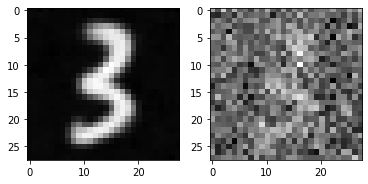

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4620.089
batch loss value:  4318.0557
batch loss value:  4687.3105
batch loss value:  4174.2334
batch loss value:  4606.3633
batch loss value:  4662.0605
batch loss value:  4791.314
batch loss value:  5003.6797
batch loss value:  4694.109
batch loss value:  4919.448
iteration: 18500 loss: 5089.625977
time step for image 69


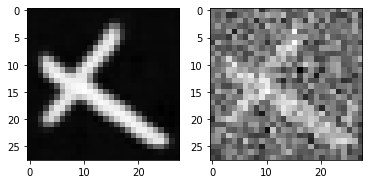

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4418.383
batch loss value:  4685.7505
batch loss value:  4700.464
batch loss value:  4545.651
batch loss value:  4456.5693
batch loss value:  4749.5083
batch loss value:  4644.29
batch loss value:  4274.1914
batch loss value:  4418.966
batch loss value:  4636.165
iteration: 18600 loss: 5069.903320
time step for image 47


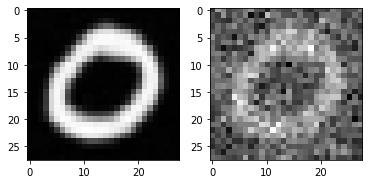

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4367.7085
batch loss value:  4178.9717
batch loss value:  4946.6416
batch loss value:  4430.3345
batch loss value:  4574.4966
batch loss value:  4644.7627
batch loss value:  5237.5957
batch loss value:  4377.459
batch loss value:  4419.8477
batch loss value:  4785.0127
iteration: 18700 loss: 4989.394531
time step for image 24


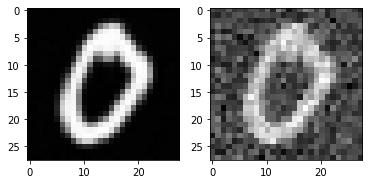

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4588.0347
batch loss value:  4595.4395
batch loss value:  4379.962
batch loss value:  4358.8877
batch loss value:  4528.0547
batch loss value:  4497.788
batch loss value:  4341.0576
batch loss value:  4530.131
batch loss value:  4442.619
batch loss value:  4537.489
iteration: 18800 loss: 4938.645508
time step for image 39


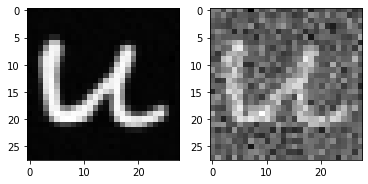

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4992.8
batch loss value:  4691.404
batch loss value:  4593.2847
batch loss value:  4376.0566
batch loss value:  4574.5674
batch loss value:  4559.5186
batch loss value:  4767.663
batch loss value:  5019.8887
batch loss value:  5108.2324
batch loss value:  4751.3364
iteration: 18900 loss: 5146.541992
time step for image 143


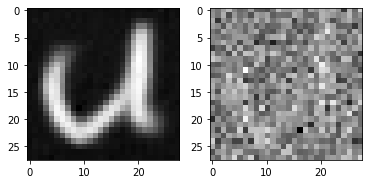

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4665.338
batch loss value:  4941.5435
batch loss value:  4914.3447
batch loss value:  5099.675
batch loss value:  4659.991
batch loss value:  4745.467
batch loss value:  4410.634
batch loss value:  4893.4316
batch loss value:  4675.3804
batch loss value:  4827.567
iteration: 19000 loss: 5150.948730
time step for image 21


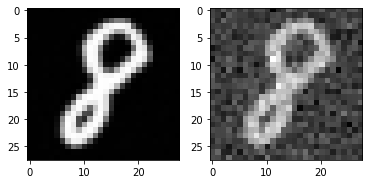

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4719.2905
batch loss value:  4489.447
batch loss value:  4383.114
batch loss value:  4991.537
batch loss value:  4777.29
batch loss value:  4714.1914
batch loss value:  4714.536
batch loss value:  4612.061
batch loss value:  4365.3633
batch loss value:  5012.2007
iteration: 19100 loss: 5151.835938
time step for image 189


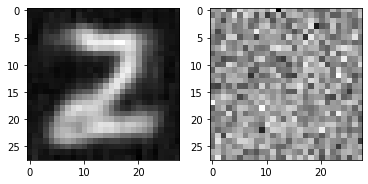

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4568.621
batch loss value:  4425.5273
batch loss value:  4293.621
batch loss value:  4485.7793
batch loss value:  4681.4717
batch loss value:  4361.229
batch loss value:  4807.2954
batch loss value:  4683.3
batch loss value:  4739.7485
batch loss value:  4711.6416
iteration: 19200 loss: 5173.046875
time step for image 82


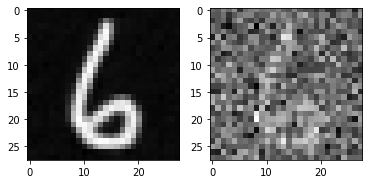

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4867.768
batch loss value:  4795.2344
batch loss value:  4376.009
batch loss value:  4678.9277
batch loss value:  4446.3633
batch loss value:  4935.5444
batch loss value:  4439.9253
batch loss value:  4487.7637
batch loss value:  4639.5957
batch loss value:  4662.2773
iteration: 19300 loss: 5131.290527
time step for image 156


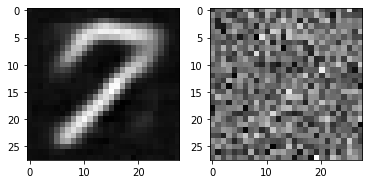

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5247.3936
batch loss value:  4581.5903
batch loss value:  4527.001
batch loss value:  4905.597
batch loss value:  4505.9043
batch loss value:  4867.542
batch loss value:  5036.3896
batch loss value:  5081.1377
batch loss value:  4677.6235
batch loss value:  4524.107
iteration: 19400 loss: 5019.684570
time step for image 16


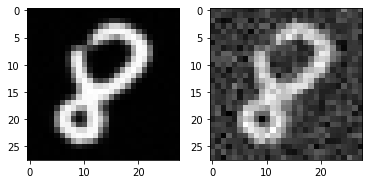

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4713.465
batch loss value:  4845.713
batch loss value:  4678.7603
batch loss value:  4756.4336
batch loss value:  4747.3384
batch loss value:  4699.159
batch loss value:  4600.374
batch loss value:  4666.5454
batch loss value:  4465.192
batch loss value:  4635.007
iteration: 19500 loss: 5009.719727
time step for image 55


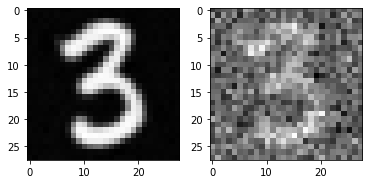

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4718.414
batch loss value:  4615.7466
batch loss value:  4393.1426
batch loss value:  4507.1855
batch loss value:  4454.9414
batch loss value:  4592.9746
batch loss value:  4786.37
batch loss value:  4504.3335
batch loss value:  4690.953
batch loss value:  4815.786
iteration: 19600 loss: 5210.083008
time step for image 143


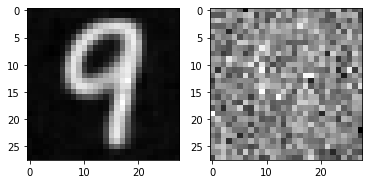

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4721.0137
batch loss value:  4749.4766
batch loss value:  4486.5
batch loss value:  4632.8545
batch loss value:  4644.83
batch loss value:  5001.28
batch loss value:  4510.589
batch loss value:  4688.5137
batch loss value:  4511.867
batch loss value:  4571.1504
iteration: 19700 loss: 5167.917969
time step for image 144


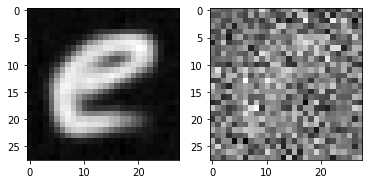

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4338.0977
batch loss value:  4606.653
batch loss value:  4452.367
batch loss value:  4783.306
batch loss value:  4462.308
batch loss value:  4718.3867
batch loss value:  4569.7744
batch loss value:  4607.036
batch loss value:  4809.9424
batch loss value:  4467.054
iteration: 19800 loss: 5115.422363
time step for image 88


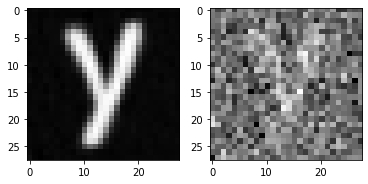

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4395.9155
batch loss value:  4403.972
batch loss value:  4768.1016
batch loss value:  5076.9253
batch loss value:  5110.287
batch loss value:  4437.046
batch loss value:  4709.573
batch loss value:  4593.5054
batch loss value:  4798.244
batch loss value:  4735.131
iteration: 19900 loss: 5001.336426
time step for image 133


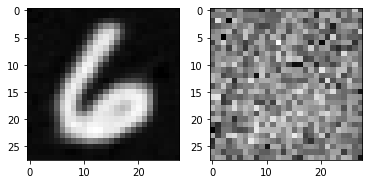

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  4709.5293
batch loss value:  4622.9873
batch loss value:  4615.0137
batch loss value:  5155.6562
batch loss value:  4795.908
batch loss value:  4250.926
batch loss value:  4681.0986
batch loss value:  4943.048
batch loss value:  4700.009


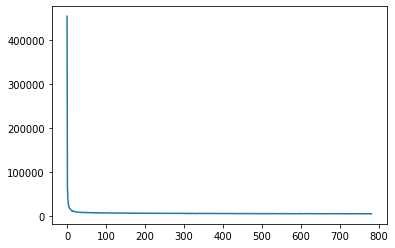

In [ ]:
data_noisy, data_in_batch, timestep, losses, avg_params = train_model(opt_state, params, avg_params, model_name, train_new_model = train_new_model, energy_method=False)
plt.plot(losses)

In [ ]:
def param_count(pytree):
  return sum(x.size for x in jax.tree_util.tree_leaves(pytree))

param_count(avg_params)

2234674

## Full generation model

In [ ]:
mean_coeff_1 = jnp.sqrt(alphas)*(1 - alphas_prev_) / variance
mean_coeff_2 = jnp.sqrt(alphas_prev_) * betas / variance

In [ ]:
import random

def generate_data(avg_params, label, energy_method=False, clipped_version=False):
    batch_size_generation = len(label)
    unique_key = jax.random.fold_in(key, random.randint(1, 100))
    _, subkey = jax.random.split(unique_key)
    _, *subkeys = jax.random.split(unique_key, timesteps+1)
    
    # need to generate new keys everytime
    data_noisy = jax.random.normal(subkey, shape=(batch_size_generation, 28, 28, 1))
      
    datas = []
    datas.append(jax.device_get(data_noisy))
    data_in_batch = data_noisy

    for t in range(1, timesteps+1):
        timestep = timesteps-t
        t_repeated = jnp.repeat(jnp.array([timestep]), batch_size_generation)
        # data_stacked = torch.vstack([data_in_batch, labelled_values])
        pred_data = net.apply(avg_params, data_in_batch, t_repeated, label)
        if not clipped_version:
            if not energy_method:
                # optimization:: not sure if exp(log(x) - log(y)) instead of x/y helps numerically
                multiplier = jnp.exp(jnp.log((betas[timestep])) - jnp.log(sd[timestep]))
                mean_data = jnp.subtract(data_in_batch, pred_data * multiplier)/jnp.sqrt(alphas[timestep])
            else:
                ##
                # Energy function interpretation
                mean_data = jnp.add(data_in_batch, pred_data * betas[timestep])/jnp.sqrt(alphas[timestep])
                ##
        else:
            # clipping an improvement as recommended in https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils.py#L171
            # this helps in improving the samples generated as it keeps the random variables in the range of -1 to +1
            if not energy_method:
                x_reconstructed = jnp.subtract(data_in_batch, pred_data * sd[timestep])/ jnp.sqrt(alphas_[timestep])
            else:
                # energy method and clipping to improve stabalization
                x_reconstructed = jnp.add(data_in_batch, pred_data * variance[timestep])/ jnp.sqrt(alphas_[timestep])

            if timestep >= 0:
                x_reconstructed = jnp.clip(x_reconstructed, 0., 1.)

            mean_data_1 = data_in_batch * mean_coeff_1[timestep]
            mean_data_2 = x_reconstructed * mean_coeff_2[timestep]
            mean_data = jnp.add(mean_data_1, mean_data_2)

        posterior_data = posterior_variance_corrected[timestep]
        data_noisy = jax.random.normal(subkeys[t-1], shape=(batch_size_generation, 28, 28, 1))
        data_in_batch = jnp.add(mean_data,  jnp.sqrt(posterior_data) * data_noisy)
        datas.append(jax.device_get(data_in_batch))
    return datas, data_in_batch

In [ ]:
batch_size_generation = 512
datas, data_in_batch = generate_data(avg_params, label=jnp.mod(jnp.arange(0, batch_size_generation), 63), energy_method=False, clipped_version=True)

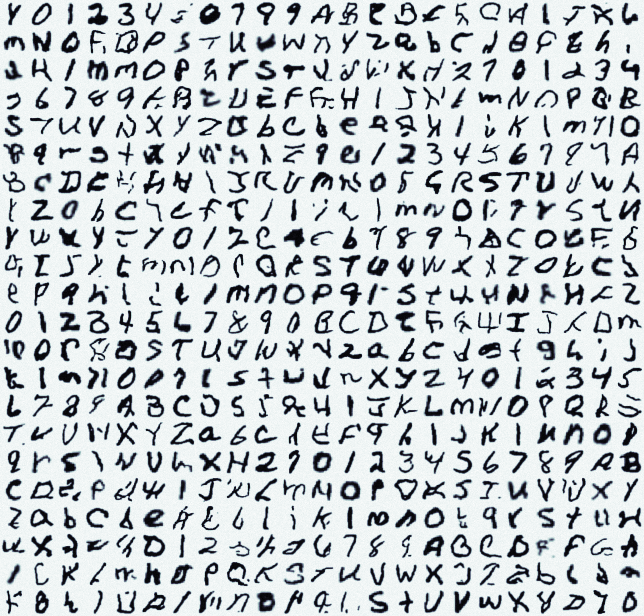

In [ ]:
rawarrview(reshape_image_batch(data_in_batch.squeeze()), cmap='bone_r')

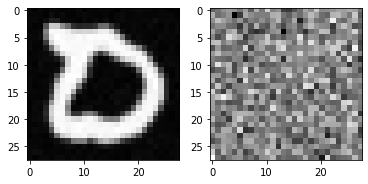

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

In [ ]:
_, (plt1, plt2) = plt.subplots(1, 2)
tt = random.randint(1, batch_size_generation)
show_image(unnormalize(data_in_batch[tt]), plt1)
show_image(unnormalize(datas[0][tt]), plt2)
# show_image((data_orig[0]), plt3)

# data_noisy, _ = get_noisy(data_orig, jnp.array([60]))
# show_image(unnormalize(data_noisy[0]), plt1)

In [ ]:
%%capture 

fig = plt.figure()
ims = []

if colab:
  datas = einops.rearrange(datas, 'x b h w c -> x b h (w c)')
  
for i in range(0, timesteps, 10):
    im = plt.imshow(datas[i][tt], cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=5, blit=True, repeat_delay=3000)
animate.save(gifs_dir + 'diffusion_generation_full_with_cond.gif', writer='pillow')

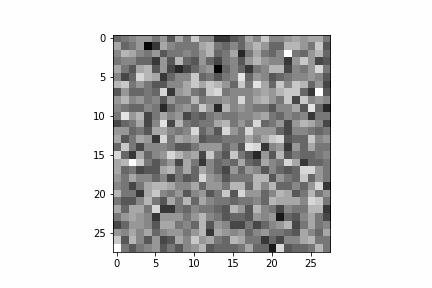

In [ ]:
with open(gifs_dir + 'diffusion_generation_full_with_cond.gif','rb') as f:
  display(Image(data=f.read(), format='png'))

## strided sampling

In [ ]:
## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L196
## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L78
posterior_variance = (betas) * (1 - alphas_prev_) / (1 - alphas_)
log_posterior_variance = jnp.log(jnp.hstack([posterior_variance[1], posterior_variance[1:]]))
posterior_variance_corrected = jnp.exp(log_posterior_variance)

strided_schedule = jnp.array(list(range(1, timesteps, 5)) + [timesteps])

alphas_strided_ = alphas_[strided_schedule]
alphas_prev_strided_ = jnp.pad(alphas_strided_[:-1], [1, 0], "constant", constant_values=1.0)

betas_strided = 1 - (alphas_strided_/alphas_prev_strided_)
posterior_variance_new_schedule = betas_strided * (1 - alphas_prev_strided_)/ (1-alphas_strided_)
log_posterior_variance = jnp.log(jnp.hstack([posterior_variance_new_schedule[1], posterior_variance_new_schedule[1:]]))
posterior_variance_new_schedule_corrected = jnp.exp(log_posterior_variance)

In [ ]:
mean_coeff_1_strided = jnp.sqrt(1-betas_strided)*(1 - alphas_prev_strided_) / (1 - alphas_strided_)
mean_coeff_2_strided = jnp.sqrt(alphas_prev_strided_) * betas_strided / (1 - alphas_strided_)

In [ ]:
import random

def generate_data_strided(avg_params, label, energy_method=False, clipped_version=False):
    batch_size_generation = len(label)
    unique_key = jax.random.fold_in(key, random.randint(1, 100))
    _, subkey = jax.random.split(unique_key)
    _, *subkeys = jax.random.split(unique_key, len(strided_schedule)+1)
    
    data_noisy = jax.random.normal(subkey, shape=(batch_size_generation, 28, 28, 1))
          
    datas = []
    datas.append(jax.device_get(data_noisy))
    data_in_batch = data_noisy                               
    for t in range(1, len(strided_schedule)+1):
        stride_timestep = len(strided_schedule)-t
        timestep = strided_schedule[stride_timestep]
        t_repeated = jnp.repeat(jnp.array([timestep]), batch_size_generation)
        # data_stacked = torch.vstack([data_in_batch, labelled_values])
        pred_data = net.apply(avg_params, data_in_batch, t_repeated, label)
        if not clipped_version:
            if not energy_method:
                # optimization:: not sure if exp(log(x) - log(y)) instead of x/y helps numerically
                multiplier = jnp.exp(jnp.log((betas_strided[stride_timestep])) - jnp.log(jnp.sqrt(1- alphas_strided_[stride_timestep])))
                mean_data = jnp.subtract(data_in_batch, pred_data * multiplier)/jnp.sqrt(1-betas_strided[stride_timestep])
            else:
                ##
                # Energy function interpretation
                mean_data = jnp.add(data_in_batch, pred_data * betas_strided[stride_timestep])/jnp.sqrt(1-betas_strided[stride_timestep])
                ##
        else:
            # clipping an improvement as recommended in https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils.py#L171
            # this helps in improving the samples generated as it keeps the random variables in the range of -1 to +1
            if not energy_method:
                x_reconstructed = jnp.subtract(data_in_batch, pred_data * sd[timestep])/ jnp.sqrt(alphas_[timestep])
            else:
                # energy method and clipping to improve stabalization
                x_reconstructed = jnp.add(data_in_batch, pred_data * variance[timestep])/ jnp.sqrt(alphas_[timestep])

            if timestep >= 0:
                x_reconstructed = jnp.clip(x_reconstructed, 0., 1.)

            mean_data_1 = data_in_batch * mean_coeff_1_strided[stride_timestep]
            mean_data_2 = x_reconstructed * mean_coeff_2_strided[stride_timestep]
            mean_data = jnp.add(mean_data_1, mean_data_2)



        posterior_data = posterior_variance_new_schedule_corrected[stride_timestep]
        data_noisy = jax.random.normal(subkeys[t-1], shape=(batch_size_generation, 28, 28, 1))
        data_in_batch = jnp.add(mean_data,  jnp.sqrt(posterior_data) * data_noisy)
        datas.append(jax.device_get(data_in_batch))
    return datas, data_in_batch

In [ ]:
batch_size_generation = 512
datas, data_in_batch = generate_data_strided(avg_params, label= jnp.mod(jnp.arange(0, batch_size_generation), 63), energy_method=False, clipped_version=True)

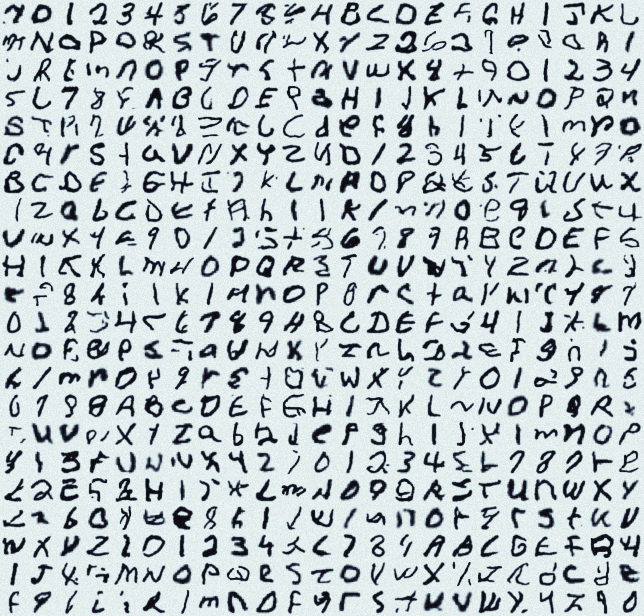

In [ ]:
rawarrview(reshape_image_batch(data_in_batch.squeeze()), cmap='bone_r')

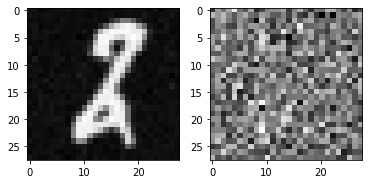

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

In [ ]:
_, (plt1, plt2) = plt.subplots(1, 2)

tt = random.randint(1, batch_size_generation)
show_image(unnormalize(data_in_batch[tt]), plt1)
show_image(unnormalize(datas[0][tt]), plt2)

# data_noisy, _ = get_noisy(data_orig, jnp.array([60]))
# show_image(unnormalize(data_noisy[0]), plt1)

In [ ]:
%%capture 

fig = plt.figure()
ims = []

if colab:
  datas = einops.rearrange(datas, 'x b h w c -> x b h (w c)')
  
for i in range(0, len(strided_schedule)):
    im = plt.imshow(datas[i][tt], cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=5, blit=True, repeat_delay=3000)
animate.save(gifs_dir + 'diffusion_generation_strided_with_cond.gif', writer='pillow')

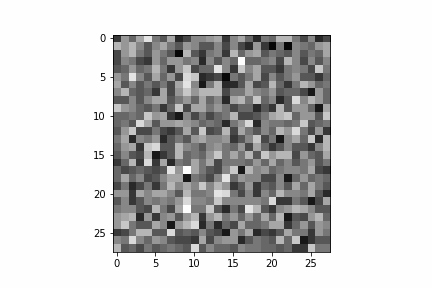

In [ ]:
with open(gifs_dir + 'diffusion_generation_strided_with_cond.gif','rb') as f:
  display(Image(data=f.read(), format='png'))

In [ ]:
import string

x = list(range(1, 63))
y = [str(i) for i in (list(range(0, 10)))] + list(string.ascii_uppercase + string.ascii_lowercase)

dict_ = {}
for i in x:
  dict_[y[i-1]] = i
  
def get_label(ans):
  return jnp.array([dict_[(char)] for char in ans])

answer = []
answer.append(get_label("varun"))
answer.append(get_label("tulsian"))
answer.append(get_label("2001"))
answer.append(get_label("gmail"))
answer.append(get_label("com"))

In [ ]:
data_in_batch = None

for l in answer:
  if data_in_batch is None:
    _, data_in_batch = generate_data(avg_params, label= l, energy_method=False, clipped_version=True)
  else:
    _, temp = generate_data(avg_params, label= l, energy_method=False, clipped_version=True)
    data_in_batch = jnp.concatenate((data_in_batch, temp), axis=0)

rawarrview(reshape_image_batch(data_in_batch.squeeze(), rows=1), cmap='bone_r')

In [ ]:
_, d = generate_data(avg_params, label= answer[0], energy_method=False, clipped_version=True)
rawarrview(reshape_image_batch(d.squeeze(), rows=1), cmap='bone_r')

In [ ]:
_, d = generate_data(avg_params, label= answer[1], energy_method=False, clipped_version=True)
rawarrview(reshape_image_batch(d.squeeze(), rows=1), cmap='bone_r')

In [ ]:
data_in_batch = None

for l in answer:
  if data_in_batch is None:
    _, data_in_batch = generate_data_strided(avg_params, label= l, energy_method=False, clipped_version=True)
  else:
    _, temp = generate_data_strided(avg_params, label= l, energy_method=False, clipped_version=True)
    data_in_batch = jnp.concatenate((data_in_batch, temp), axis=0)

rawarrview(reshape_image_batch(data_in_batch.squeeze(), rows=1), cmap='bone_r')

In [ ]:
_, d = generate_data_strided(avg_params, label= answer[0], energy_method=False, clipped_version=True)
rawarrview(reshape_image_batch(d.squeeze(), rows=1), cmap='bone_r')

In [ ]:
_, d = generate_data_strided(avg_params, label= answer[1], energy_method=False, clipped_version=True)
rawarrview(reshape_image_batch(d.squeeze(), rows=1), cmap='bone_r')